# Wasserstien Auto-Encoder

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
print ("TF version: %s"%(tf.__version__))

TF version: 1.12.0


### Define WAE Class

In [4]:
import numpy.matlib as npm
class HyperSphereInsideSamplerClass(object):
    def __init__(self,name='hyper_sphere_inside_sampler',r=1,z_dim=16):
        self.name = name
        self.r = r
        self.z_dim = z_dim

    def sampler(self,n):
        z = np.random.randn(n,self.z_dim)
        z_norm = np.linalg.norm(z,axis=1)
        z_unit = z / npm.repmat(z_norm.reshape((-1,1)),1,self.z_dim) # on the surface of a hypersphere
        u = np.power(np.random.rand(n,1),(1/self.z_dim)*np.ones(shape=(n,1)))
        z_sphere = self.r * z_unit * npm.repmat(u,1,self.z_dim) # samples inside the hypersphere
        samples = z_sphere 
        return samples

    def plot(self,n=1000,tfs=20):
        samples = self.sampler(n=n)
        plt.figure(figsize=(6,6))
        plt.plot(samples[:,0],samples[:,1],'k.')
        plt.xlim(-self.r,self.r)
        plt.ylim(-self.r,self.r)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title(self.name,fontsize=tfs)
        plt.show()    
        
class WassersteinAutoEncoderClass(object):
    """
    WAE implementation
    """
    def __init__(self,name='wae',xdim=784,zdim=16,
                 hdims_Q=[256]*2,hdims_P=[256]*2,hdims_D=[256]*2,
                 actv_Q=tf.nn.relu,actv_P=tf.nn.relu,actv_D=tf.nn.relu,
                 actv_out=tf.nn.sigmoid,
                 beta=1.0):
        self.name = name
        self.xdim = xdim
        self.zdim = zdim
        self.hdims_Q = hdims_Q
        self.hdims_P = hdims_P
        self.hdims_D = hdims_D
        self.actv_Q = actv_Q
        self.actv_P = actv_P
        self.actv_D = actv_D
        self.actv_out = actv_out
        self.beta = beta
        
        self.z_radius = 1.0
        self.S = HyperSphereInsideSamplerClass(r=self.z_radius,z_dim=self.zdim)
        
        with tf.variable_scope(self.name,reuse=False):
            self.build_graph()
            
    def build_graph(self):
        kernel_init = tf.truncated_normal_initializer(mean=0.0,stddev=0.1)
        bias_init = tf.constant_initializer(value=0.0)
        
        self.ph_x_real = tf.placeholder(shape=[None,self.xdim],dtype=tf.float32,name='x_real') # [n x x_dim]
        self.ph_x_trgt = tf.placeholder(shape=[None,self.xdim],dtype=tf.float32,name='x_trgt') # [n x x_dim]
        self.ph_z_sample = tf.placeholder(shape=[None,self.zdim],dtype=tf.float32,name='z_sample') # [n x z_dim]
        self.lr = tf.placeholder(shape=[],dtype=tf.float32,name='lr') # [1]
        self.n = tf.shape(self.ph_x_real)[0] # number of batch
        
        # Encoder netowrk Q(z|x): x_real => z_real
        with tf.variable_scope('Q',reuse=False):
            net = self.ph_x_real
            for h_idx,hdim in enumerate(self.hdims_Q):
                net = tf.layers.dense(net,hdim,activation=self.actv_Q,
                                      kernel_initializer=kernel_init,bias_initializer=bias_init,
                                      name='hid_Q_lin_%d'%(h_idx))
            self.z_real = tf.layers.dense(net,self.zdim,activation=None,
                                          kernel_initializer=kernel_init,bias_initializer=bias_init,
                                          name='z_real') # [n x z_dim]
            
        # Decoder netowrk P(x|z): z_sample => x_sample
        with tf.variable_scope('P',reuse=False):
            net = self.ph_z_sample
            for h_idx,hdim in enumerate(self.hdims_P):
                net = tf.layers.dense(net,hdim,activation=self.actv_P,
                                      kernel_initializer=kernel_init,bias_initializer=bias_init,
                                      name='hid_P_lin_%d'%(h_idx))
            # Recon
            self.x_sample = tf.layers.dense(net,self.xdim,activation=self.actv_out,
                                           kernel_initializer=kernel_init,bias_initializer=bias_init,
                                           name='x_recon') # [n x x_dim]
            
        # Decoder netowrk P(x|z): z_real => x_recon
        with tf.variable_scope('P',reuse=True):
            net = self.z_real
            for h_idx,hdim in enumerate(self.hdims_P):
                net = tf.layers.dense(net,hdim,activation=self.actv_P,
                                      kernel_initializer=kernel_init,bias_initializer=bias_init,
                                      name='hid_P_lin_%d'%(h_idx))
            # Recon
            self.x_recon = tf.layers.dense(net,self.xdim,activation=self.actv_out,
                                            kernel_initializer=kernel_init,bias_initializer=bias_init,
                                            name='x_recon') # [n x x_dim]
        
        # Discriminator D(z): z_real => d_real
        with tf.variable_scope('D',reuse=False):
            net = self.z_real
            for h_idx,hdim in enumerate(self.hdims_D):
                net = tf.layers.dense(net,hdim,activation=self.actv_D,
                                      kernel_initializer=kernel_init,bias_initializer=bias_init,
                                      name='hid_D_lin_%d'%(h_idx))
            self.d_real_logits = tf.layers.dense(net,1,activation=None,
                                                 kernel_initializer=kernel_init,bias_initializer=bias_init,
                                                 name='d_logits') # [n x 1]
            self.d_real = tf.sigmoid(self.d_real_logits,name='d') # [n x 1]
        
        # (Reusing) Discriminator D(z): z_sample => d_fake
        with tf.variable_scope('D',reuse=True):
            net = self.ph_z_sample
            for h_idx,hdim in enumerate(self.hdims_D):
                net = tf.layers.dense(net,hdim,activation=self.actv_D,
                                      kernel_initializer=kernel_init,bias_initializer=bias_init,
                                      name='hid_D_lin_%d'%(h_idx))
            self.d_fake_logits = tf.layers.dense(net,1,activation=None,
                                                 kernel_initializer=kernel_init,bias_initializer=bias_init,
                                                 name='d_logits') # [n x 1]
            self.d_fake = tf.sigmoid(self.d_fake_logits,name='d') # [n x 1]
        
        # Loss 
        tfscewl = tf.nn.sigmoid_cross_entropy_with_logits
        self.d_loss_reals = tfscewl(logits=self.d_real_logits,labels=tf.zeros_like(self.d_real_logits)) # [n x 1]
        self.d_loss_fakes = tfscewl(logits=self.d_fake_logits,labels=tf.ones_like(self.d_fake_logits)) # [n x 1]
        self.d_losses = 1.0*self.d_loss_reals + 1.0*self.d_loss_fakes # [n x 1] -> adversarial loss? 
        self.g_losses = tfscewl(logits=self.d_real_logits,labels=tf.ones_like(self.d_real_logits)) # [n x 1]
        
        self.d_losses = self.beta*self.d_losses # [n x 1]
        self.g_losses = self.beta*self.g_losses # [n x 1]

        self.l1_losses = tf.reduce_sum(tf.abs(self.x_recon-self.ph_x_trgt),axis=1) # [n x 1] L1 norm
        self.l2_losses = tf.reduce_sum((self.x_recon-self.ph_x_trgt)**2,axis=1) # [n x 1] L2 norm
        self.recon_losses = self.l2_losses # [n x 1] reconstruction loss

        self.d_loss = tf.reduce_mean(self.d_losses) # [1]
        self.g_loss = tf.reduce_mean(self.g_losses) # [1]
        self.recon_loss = tf.reduce_mean(self.recon_losses) # [1]
        
        self.t_vars = [var for var in tf.trainable_variables() if '%s/'%(self.name) in var.name] 
        self.q_vars = [var for var in self.t_vars if '%s/Q'%(self.name) in var.name] # encoder 
        self.p_vars = [var for var in self.t_vars if '%s/P'%(self.name) in var.name] # encoder 
        self.d_vars = [var for var in self.t_vars if '%s/D'%(self.name) in var.name] # discriminator
        self.ae_vars = self.q_vars + self.p_vars # both encoder and decoder
        
        self.lr_d_weight = tf.placeholder(shape=[],dtype=tf.float32,name='lr_d_weight') # 1/10
        self.lr_g_weight = tf.placeholder(shape=[],dtype=tf.float32,name='lr_g_weight') # 1/2
        
        beta1,beta2 = 0.5,0.9 # 0.5,0.9
        self.optm_recon = tf.train.AdamOptimizer(self.lr,beta1=beta1,beta2=beta2).minimize(self.recon_loss,var_list=self.ae_vars)
        self.optm_d = tf.train.AdamOptimizer(self.lr*self.lr_d_weight,beta1=beta1,beta2=beta2).minimize(self.d_loss,var_list=self.d_vars)
        self.optm_g = tf.train.AdamOptimizer(self.lr*self.lr_g_weight,beta1=beta1,beta2=beta2).minimize(self.g_loss,var_list=self.q_vars)
        
    # Update network parameters
    def update(self,sess,x_batch,
               n_g_update=2,lr=0.001,lr_d_weight=0.1,lr_g_weight=0.5):
        batch_size = x_batch.shape[0]
        z_sample = self.S.sampler(batch_size)
        feeds = {self.ph_x_real:x_batch,self.ph_x_trgt:x_batch,self.ph_z_sample:z_sample,
                 self.lr_d_weight:lr_d_weight,self.lr_g_weight:lr_g_weight,
                 self.lr:lr}
        
        # Update discriminator 
        d_loss,_ = sess.run([self.d_loss,self.optm_d],feed_dict=feeds)
        
        # Update generator 
        for _ in range(n_g_update): 
            g_loss,_ = sess.run([self.g_loss,self.optm_g],feed_dict=feeds)
        
        # Update both encoder and decoder (reconstruction loss)
        recon_loss,_ = sess.run([self.recon_loss,self.optm_recon],feed_dict=feeds)
        
        return recon_loss,d_loss,g_loss
print ("WAE class ready.")

WAE class ready.


### Train WAE with MNIST 

In [5]:
def gpu_sess(): 
    config = tf.ConfigProto(); 
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    return sess    

In [6]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() 
x,y = X_train.reshape(60000,784)/255,Y_train
n = x.shape[0]
tf.reset_default_graph()
W = WassersteinAutoEncoderClass(
    name='wae',xdim=784,zdim=2,
    hdims_Q=[256]*2,hdims_P=[256]*2,hdims_D=[256]*2,
    actv_Q=tf.nn.relu,actv_P=tf.nn.relu,actv_D=tf.nn.relu,
    actv_out=tf.nn.sigmoid,
    beta=1.0)
sess = gpu_sess()
print ("[%s] instantiated."%(W.name))

[wae] instantiated.


### Loop

[0/50] recon:[0.447] d:[0.015] g:[0.007].


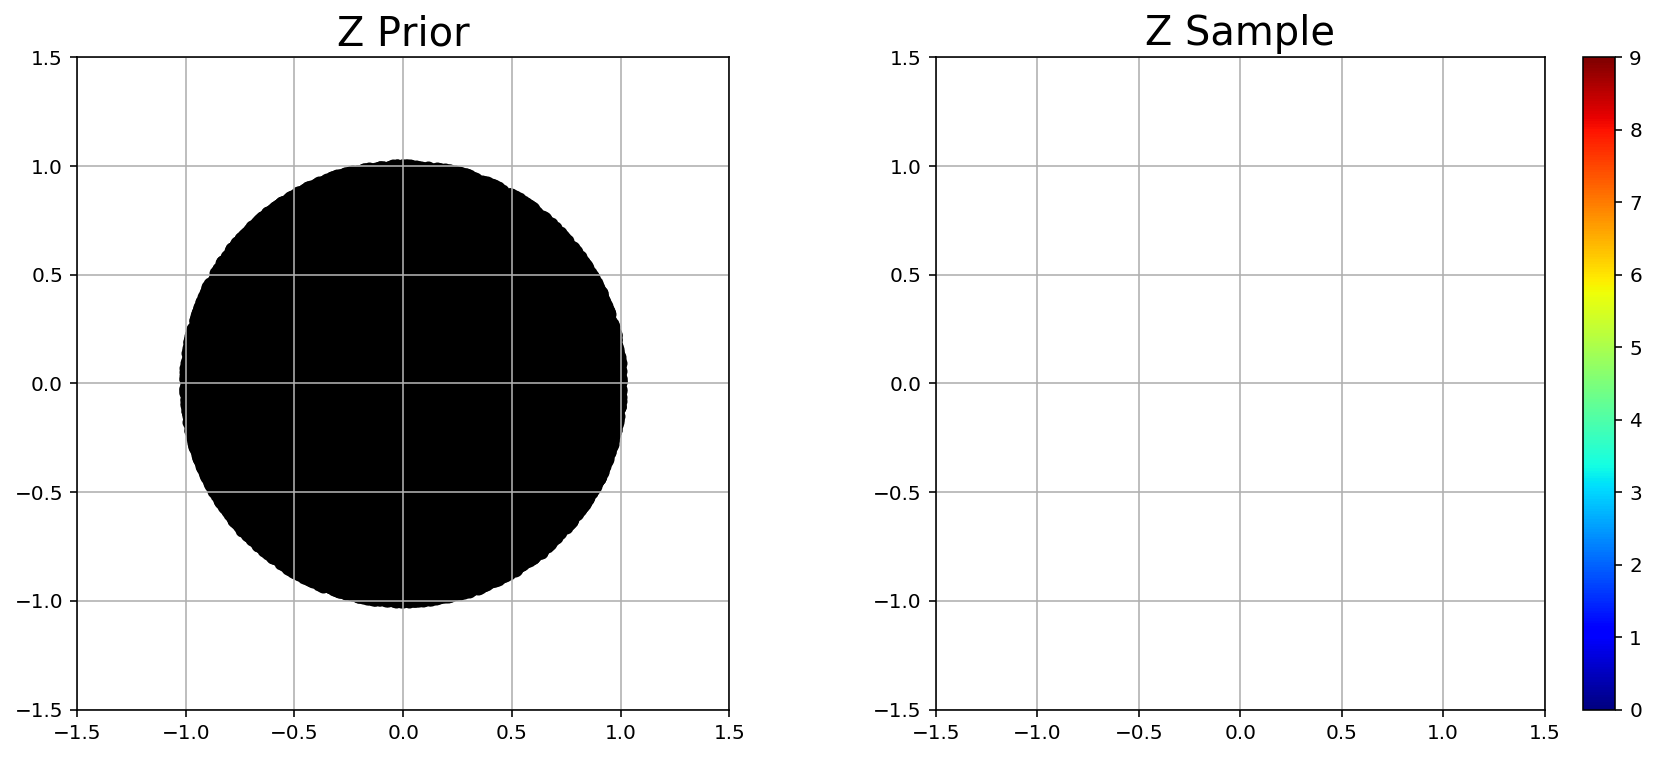

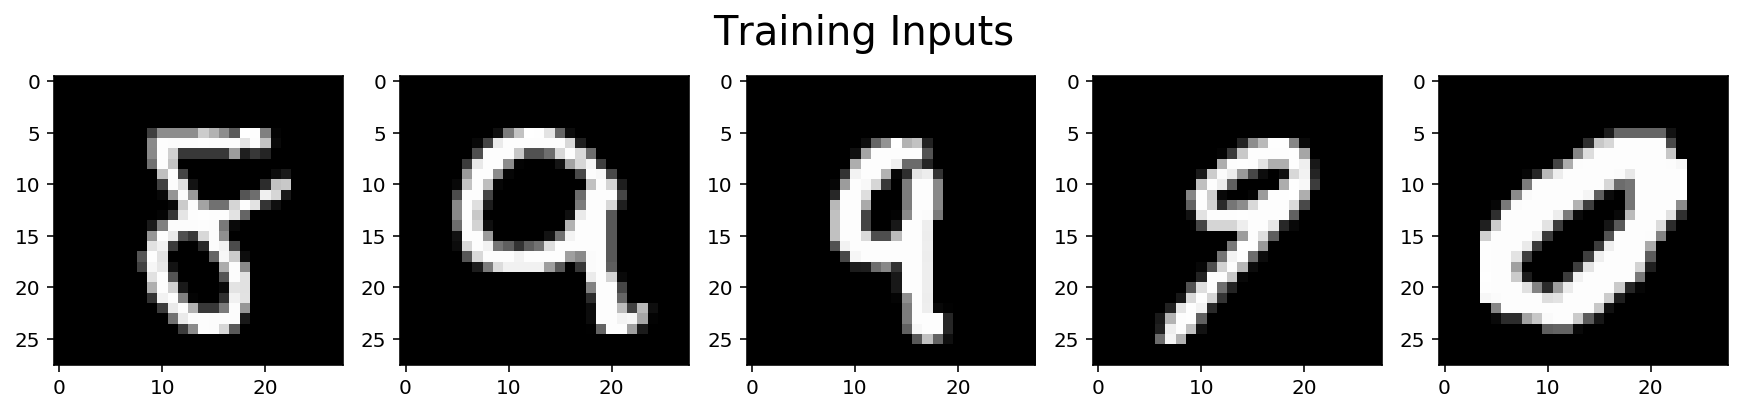

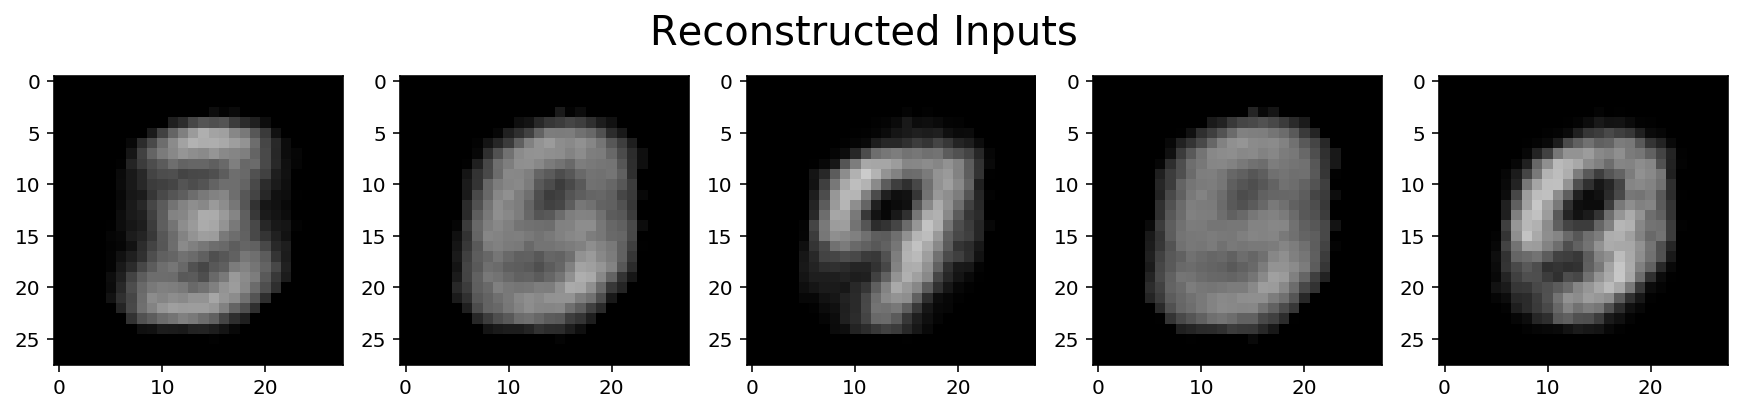

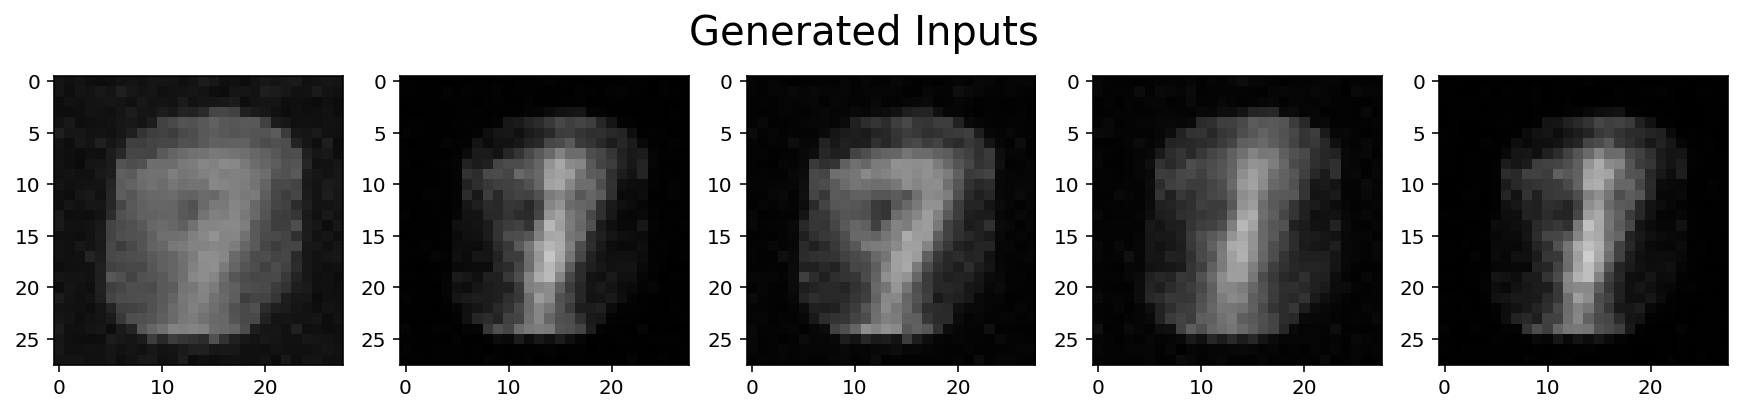

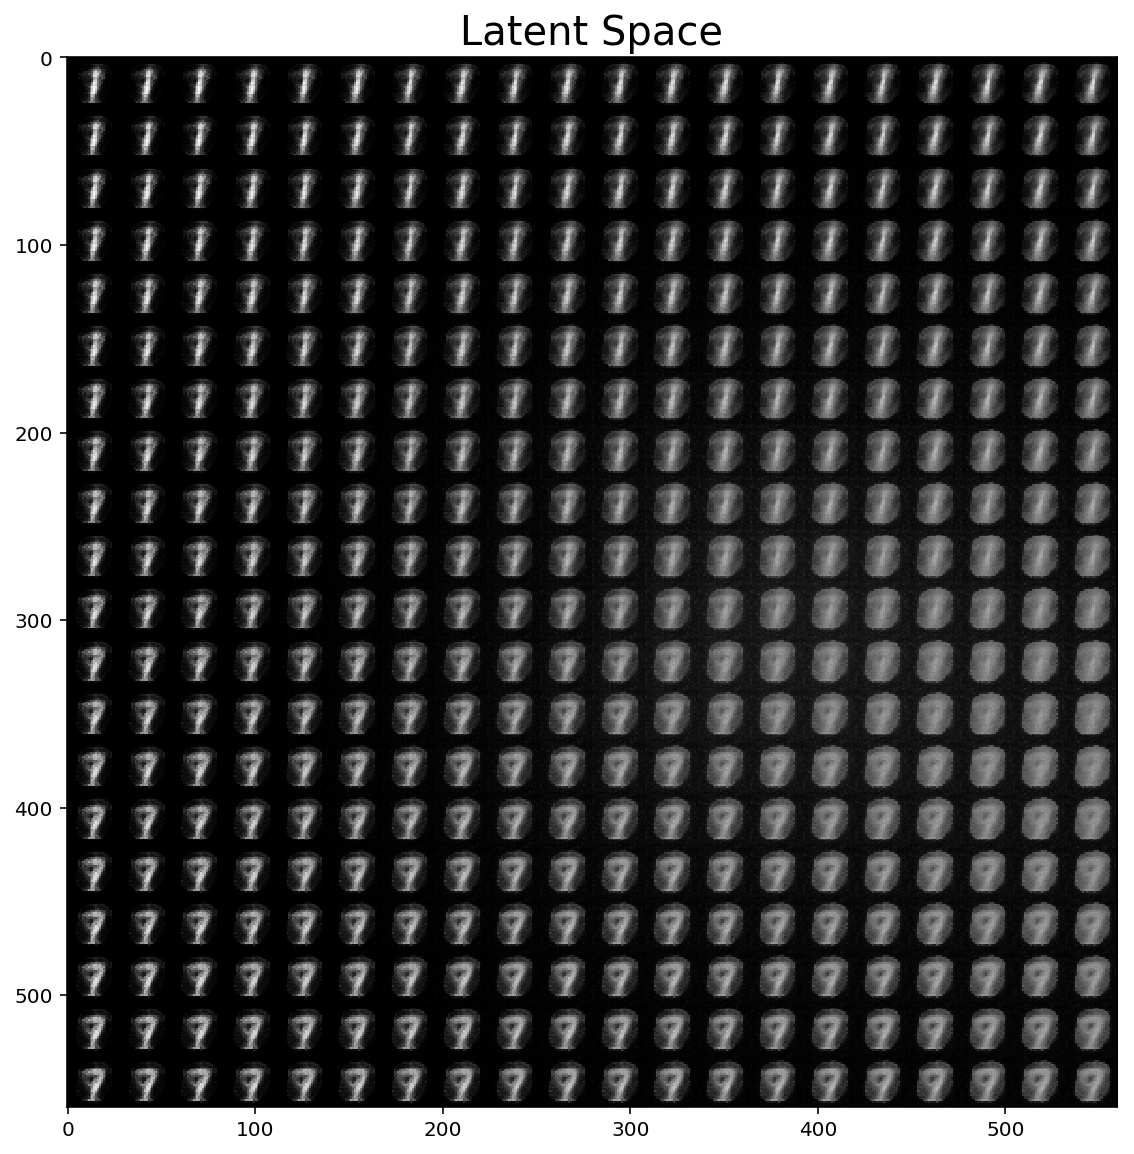

[1/50] recon:[0.360] d:[0.011] g:[0.006].
[2/50] recon:[0.351] d:[0.011] g:[0.005].
[3/50] recon:[0.337] d:[0.011] g:[0.005].
[4/50] recon:[0.331] d:[0.011] g:[0.005].
[5/50] recon:[0.325] d:[0.011] g:[0.005].


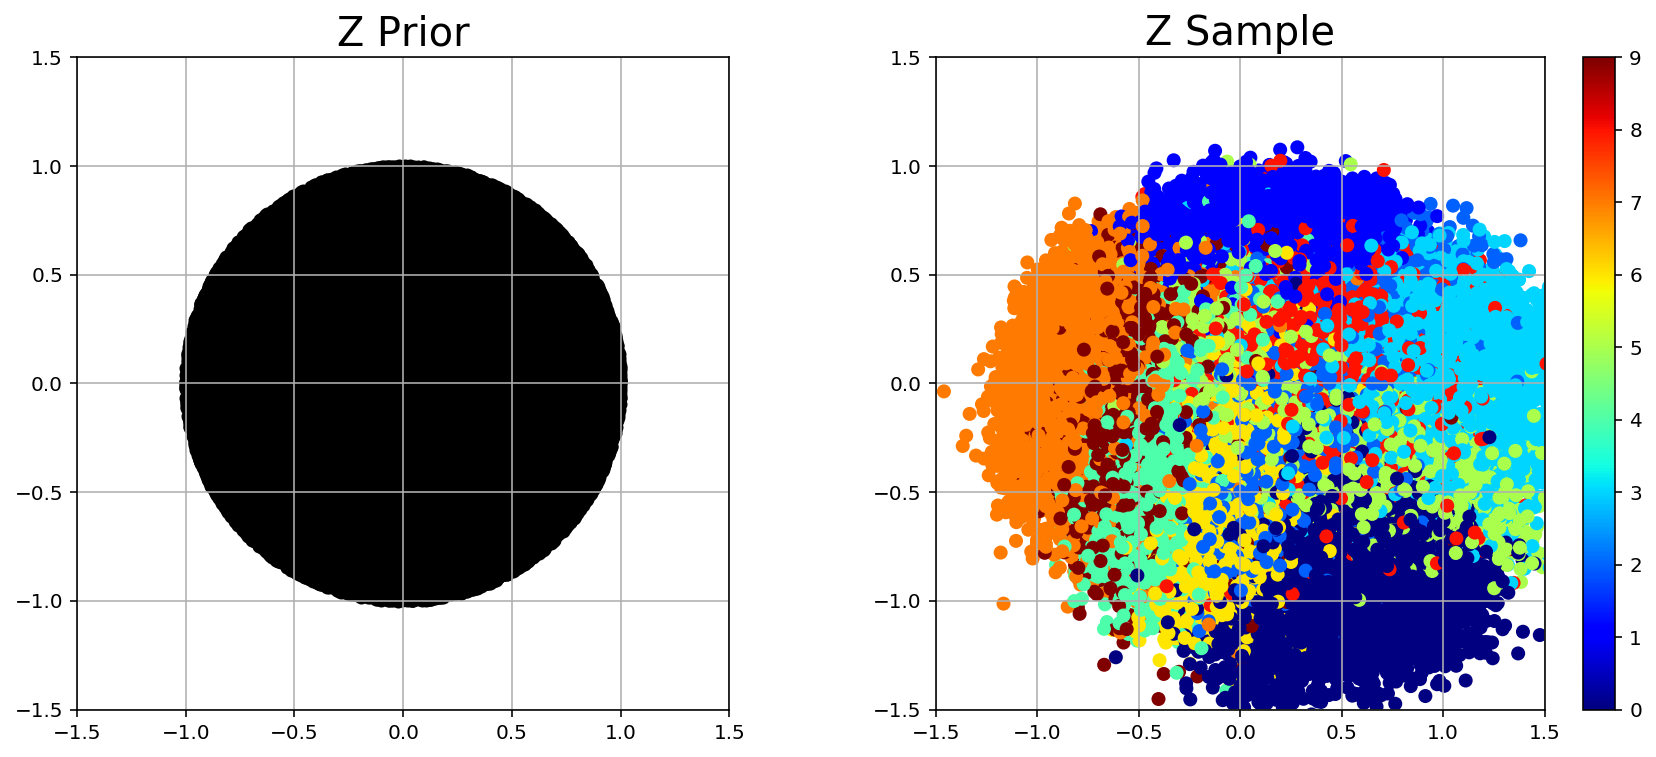

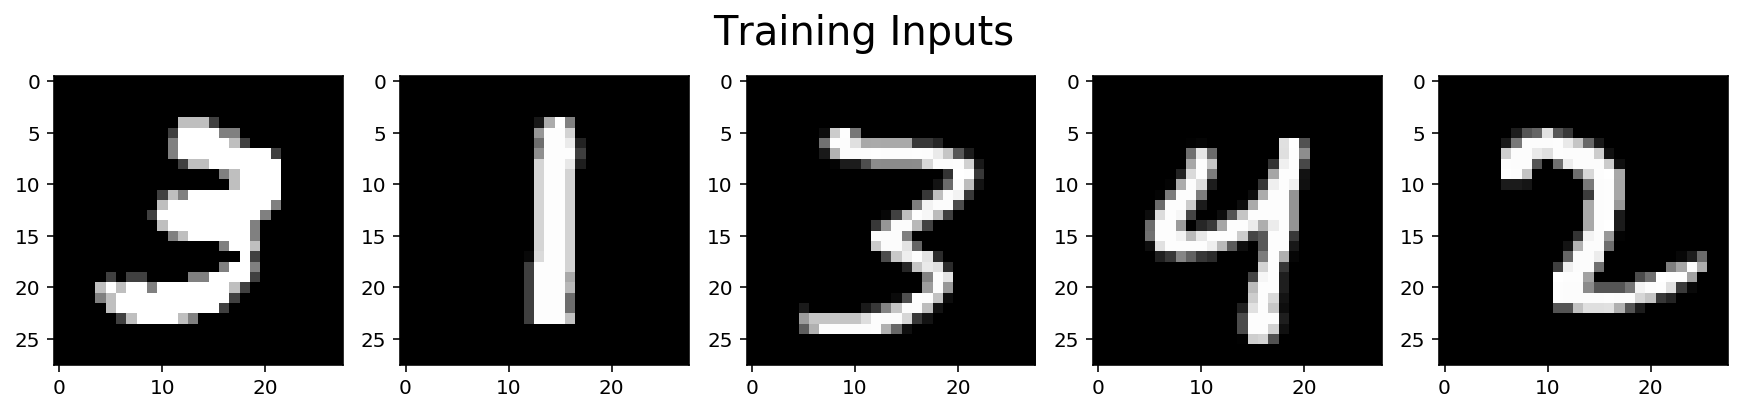

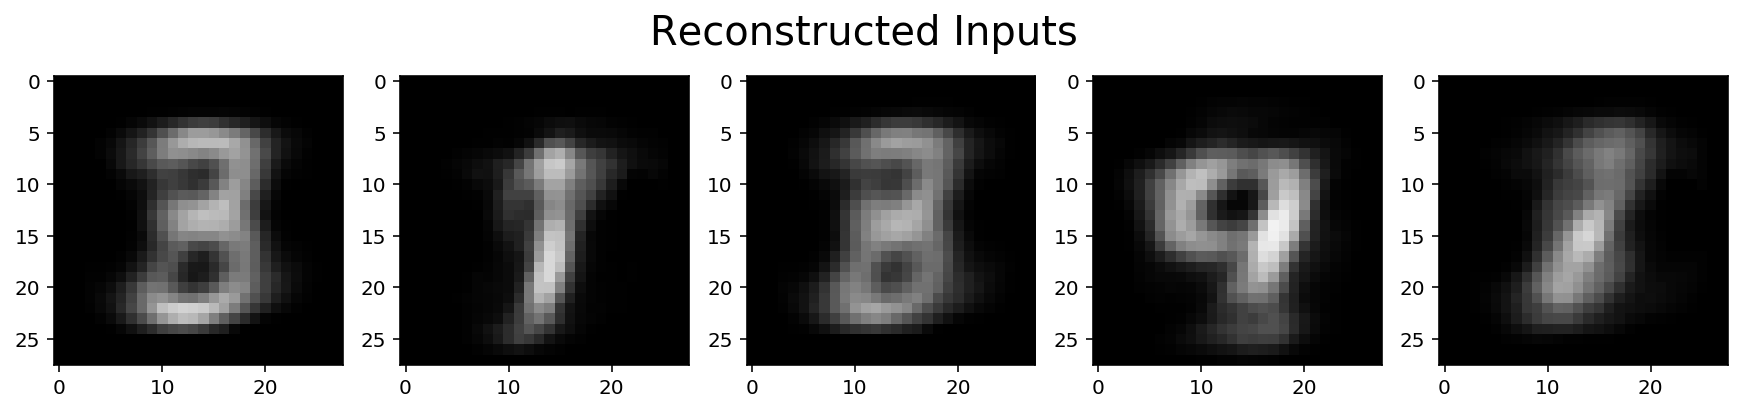

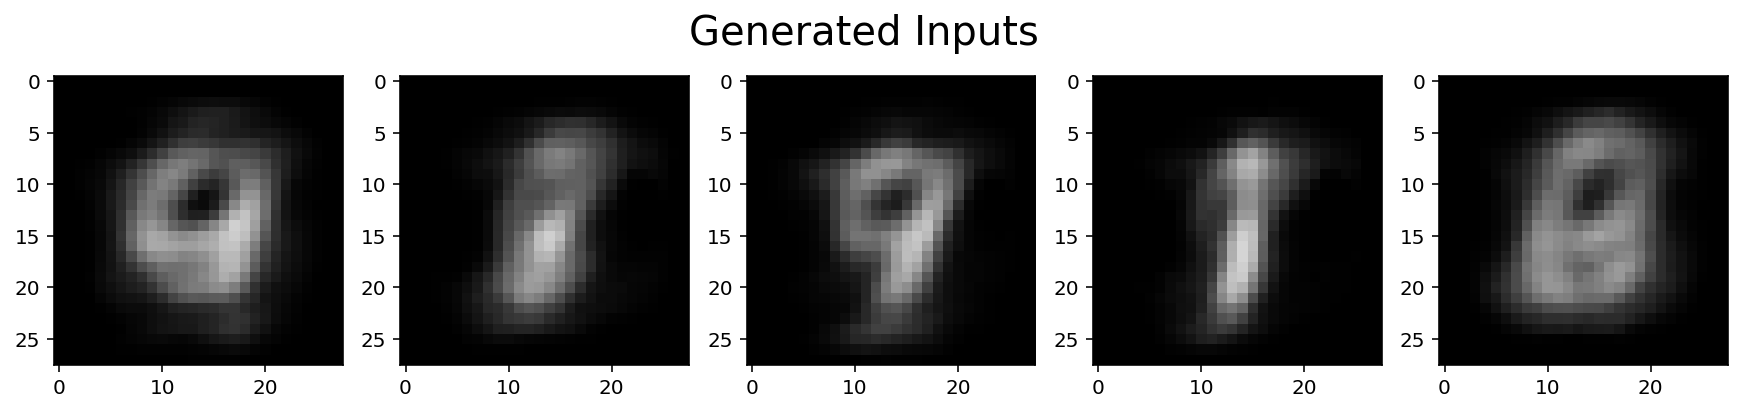

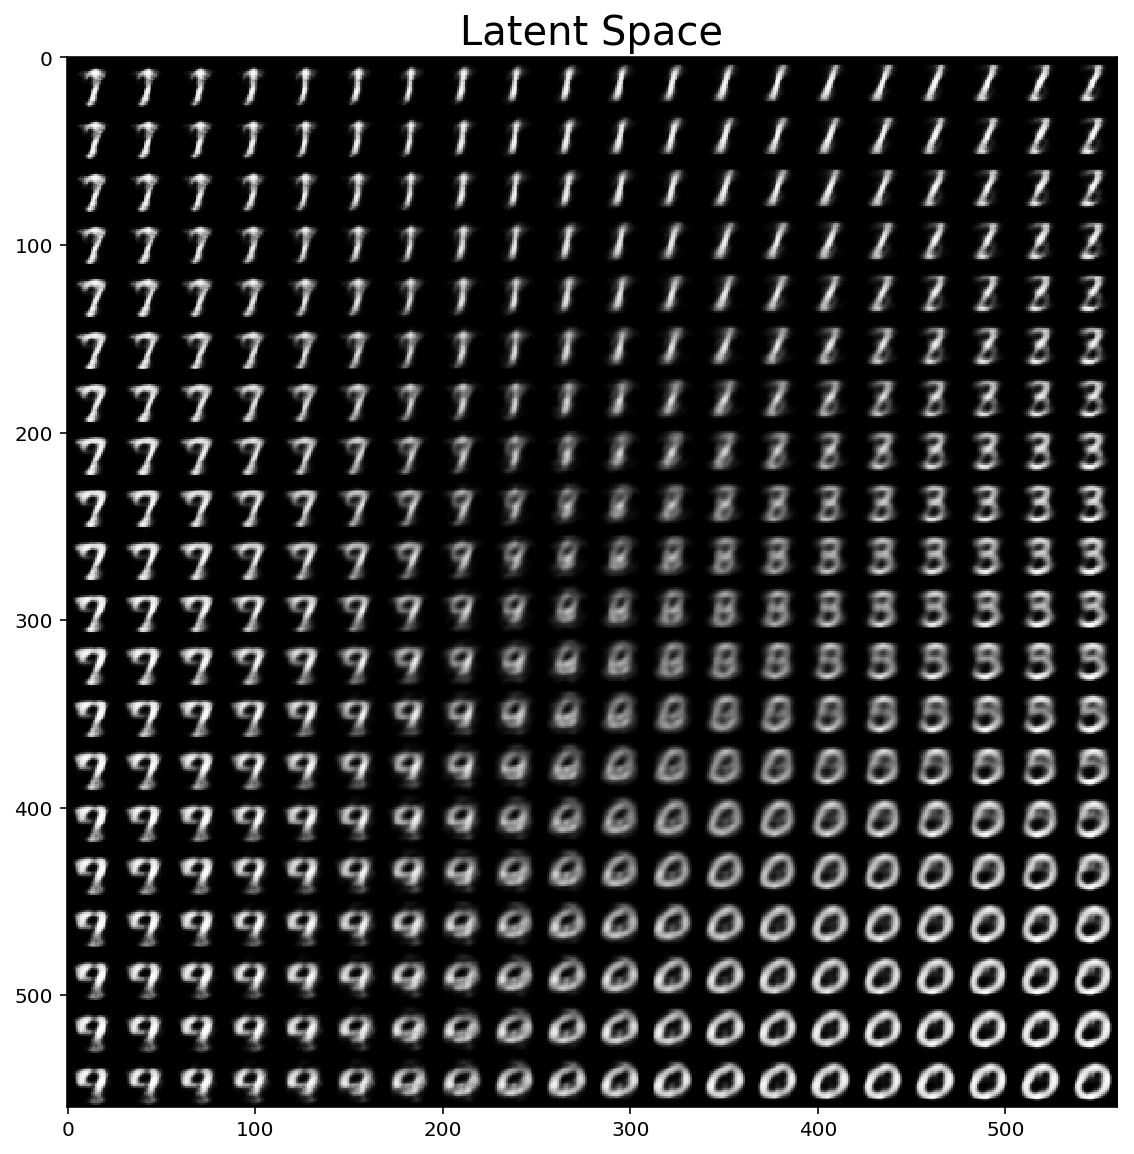

[6/50] recon:[0.322] d:[0.011] g:[0.005].
[7/50] recon:[0.317] d:[0.011] g:[0.005].
[8/50] recon:[0.314] d:[0.011] g:[0.005].
[9/50] recon:[0.311] d:[0.011] g:[0.005].
[10/50] recon:[0.307] d:[0.011] g:[0.005].


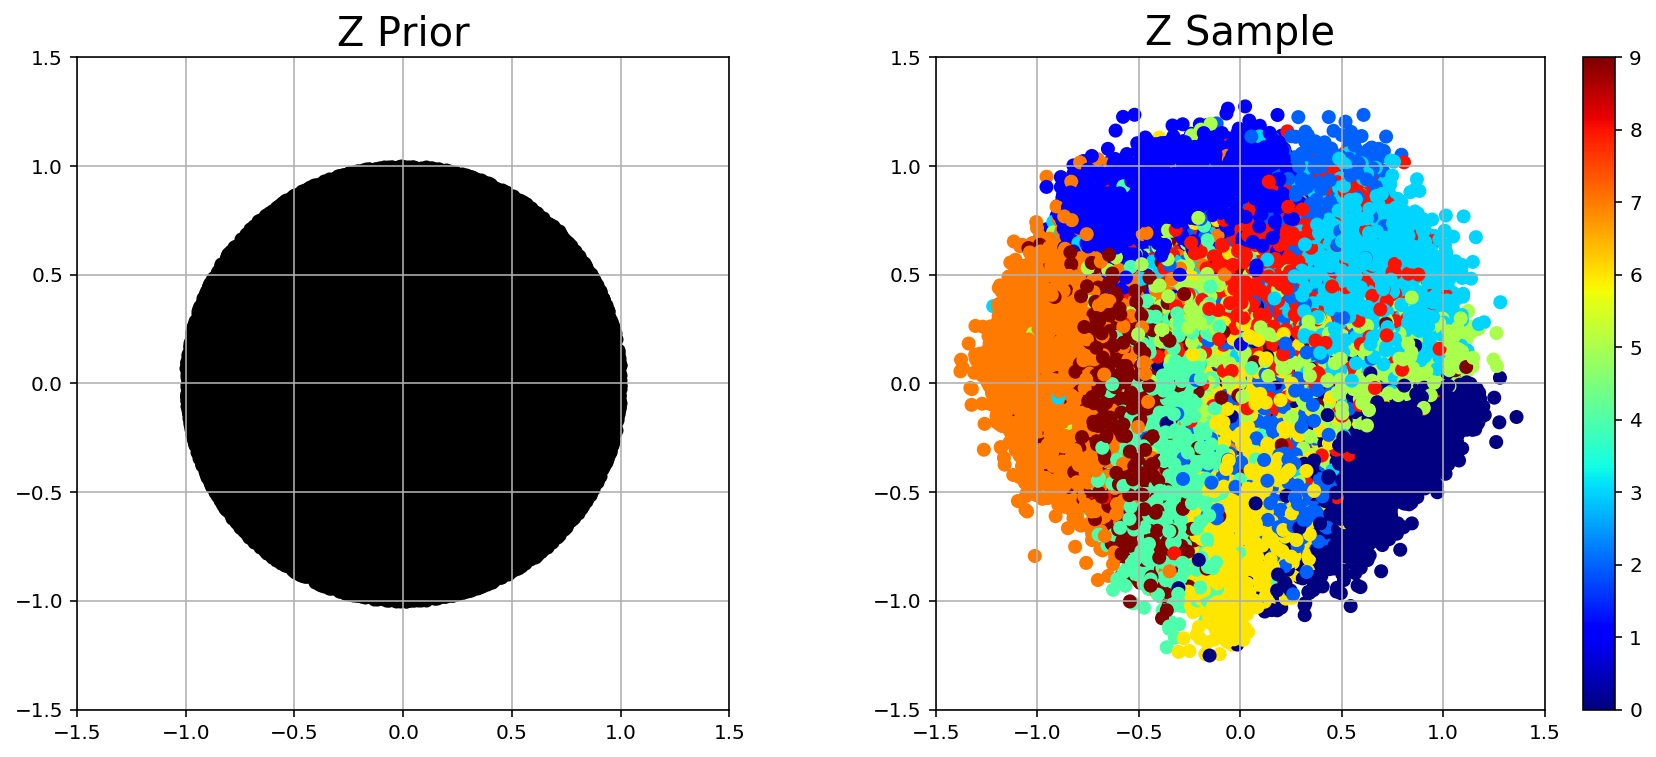

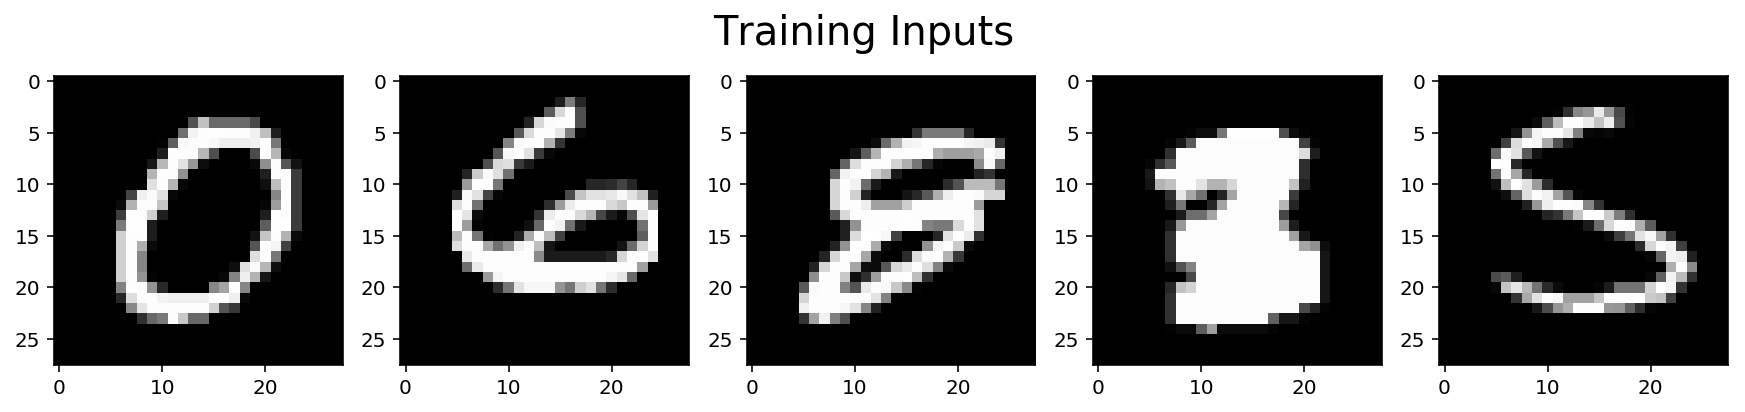

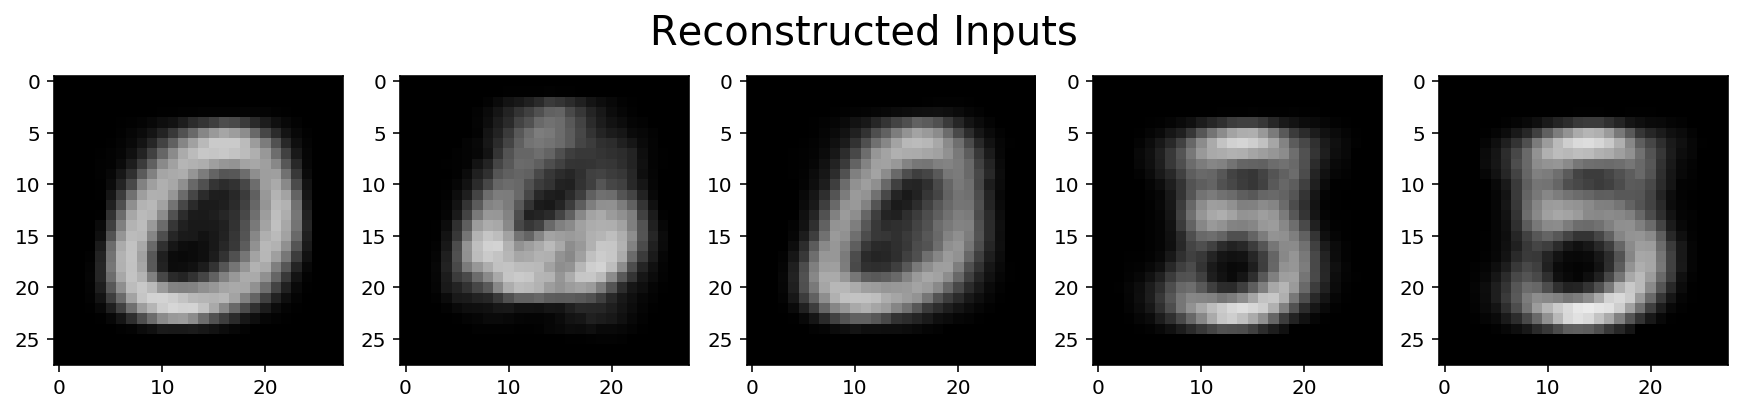

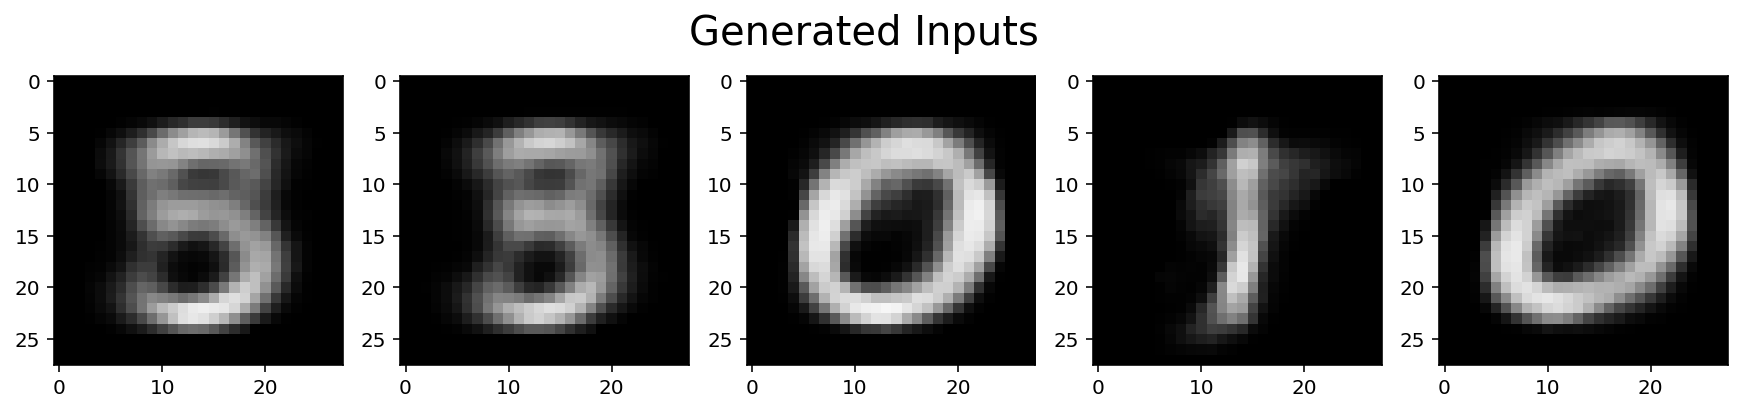

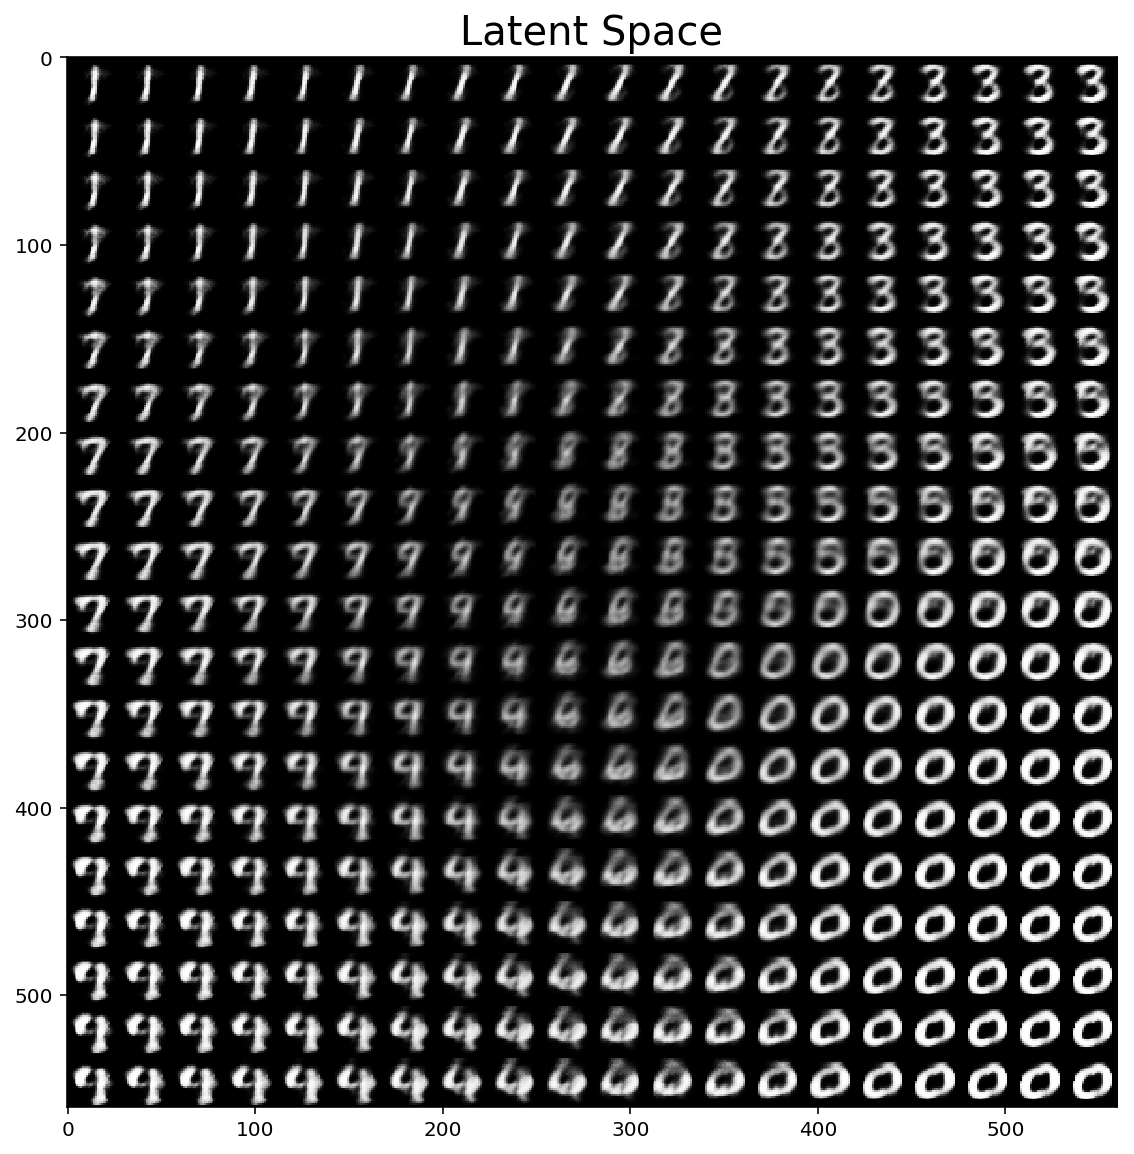

[11/50] recon:[0.304] d:[0.011] g:[0.005].
[12/50] recon:[0.301] d:[0.011] g:[0.005].
[13/50] recon:[0.299] d:[0.011] g:[0.005].
[14/50] recon:[0.297] d:[0.011] g:[0.005].
[15/50] recon:[0.295] d:[0.011] g:[0.005].


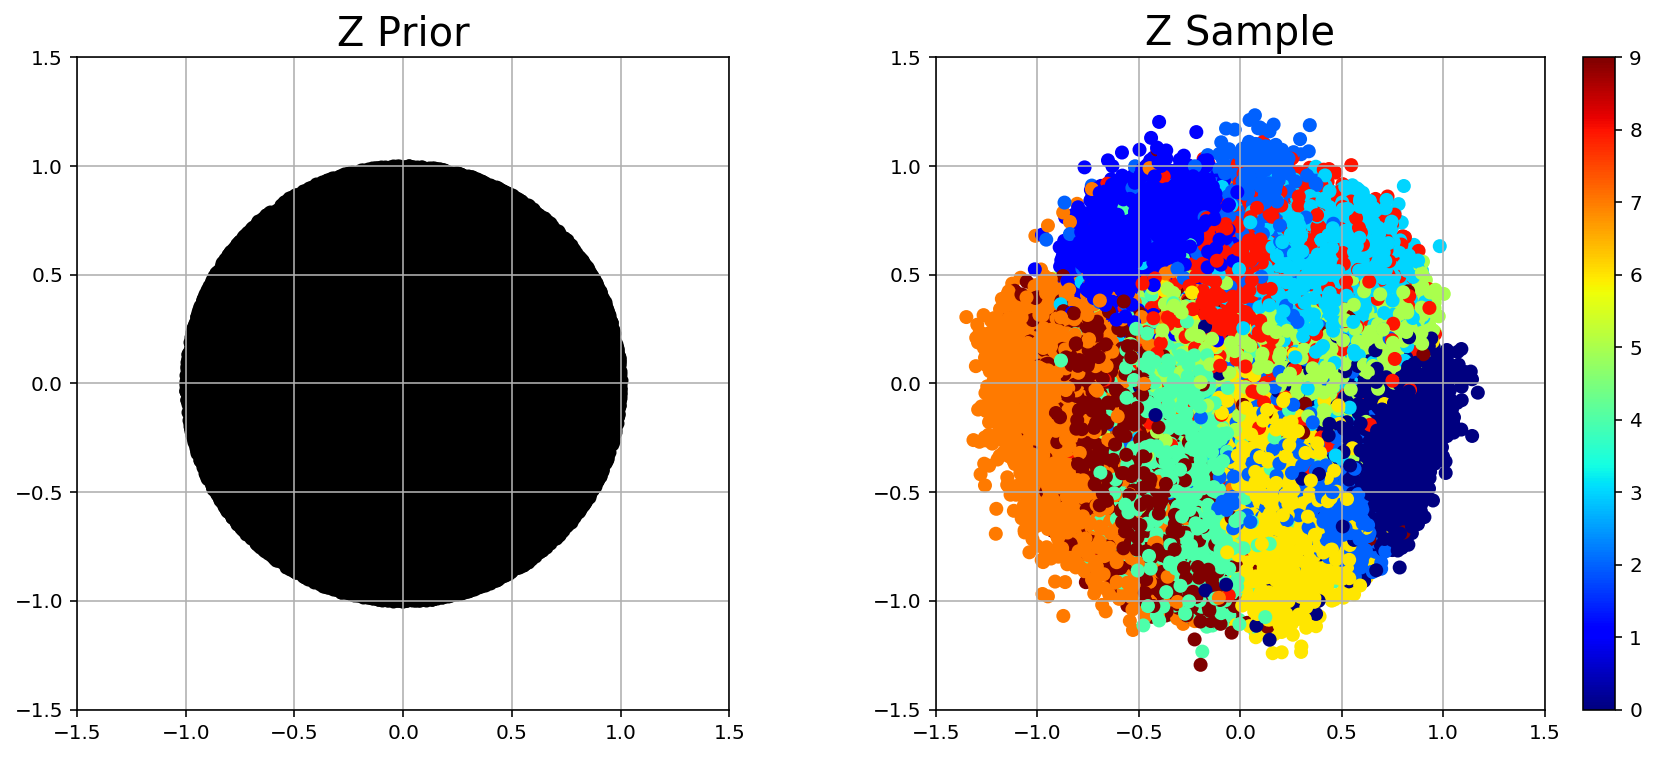

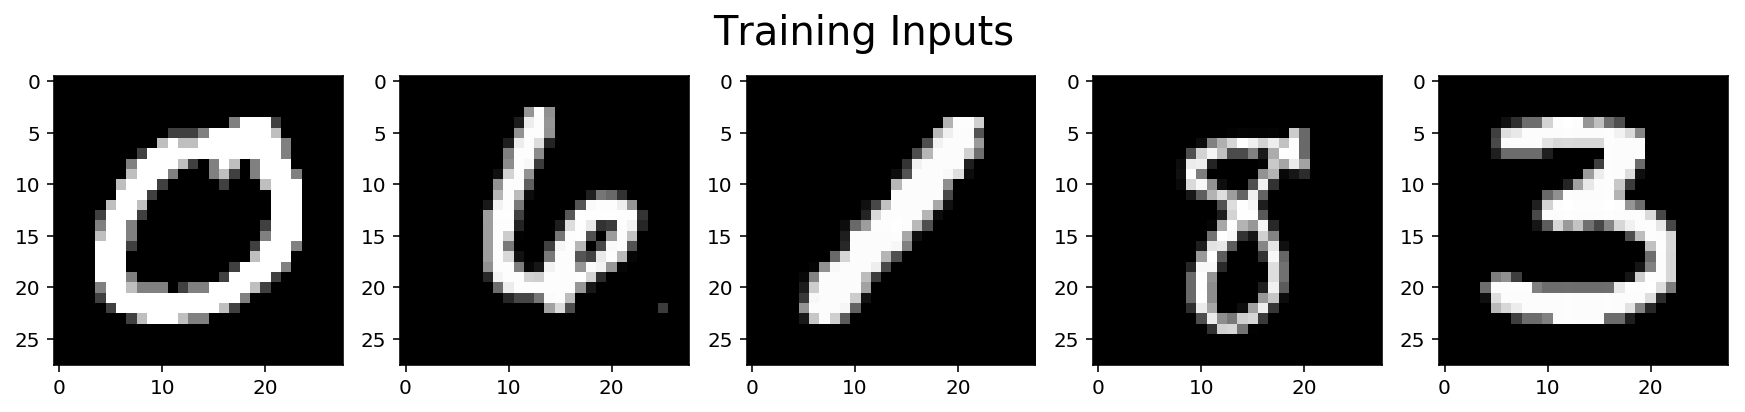

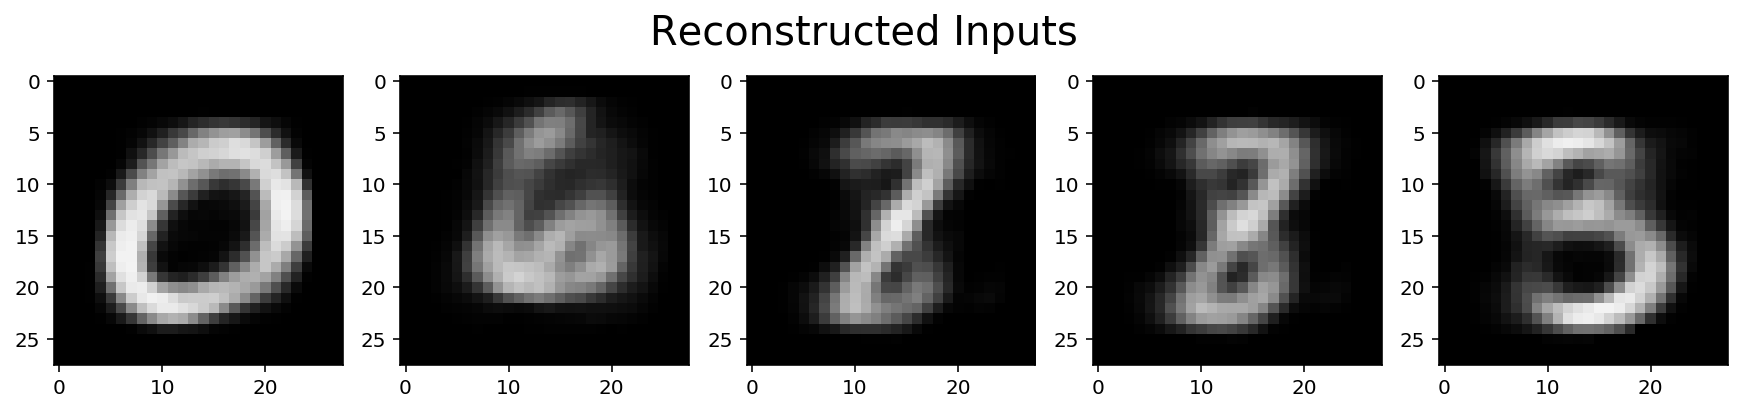

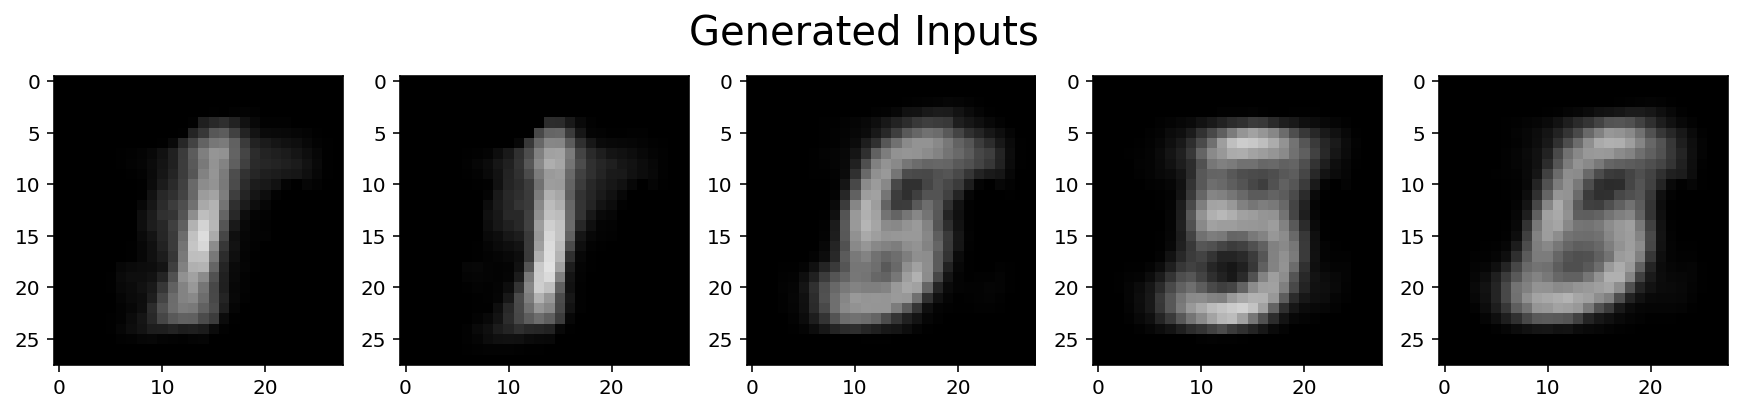

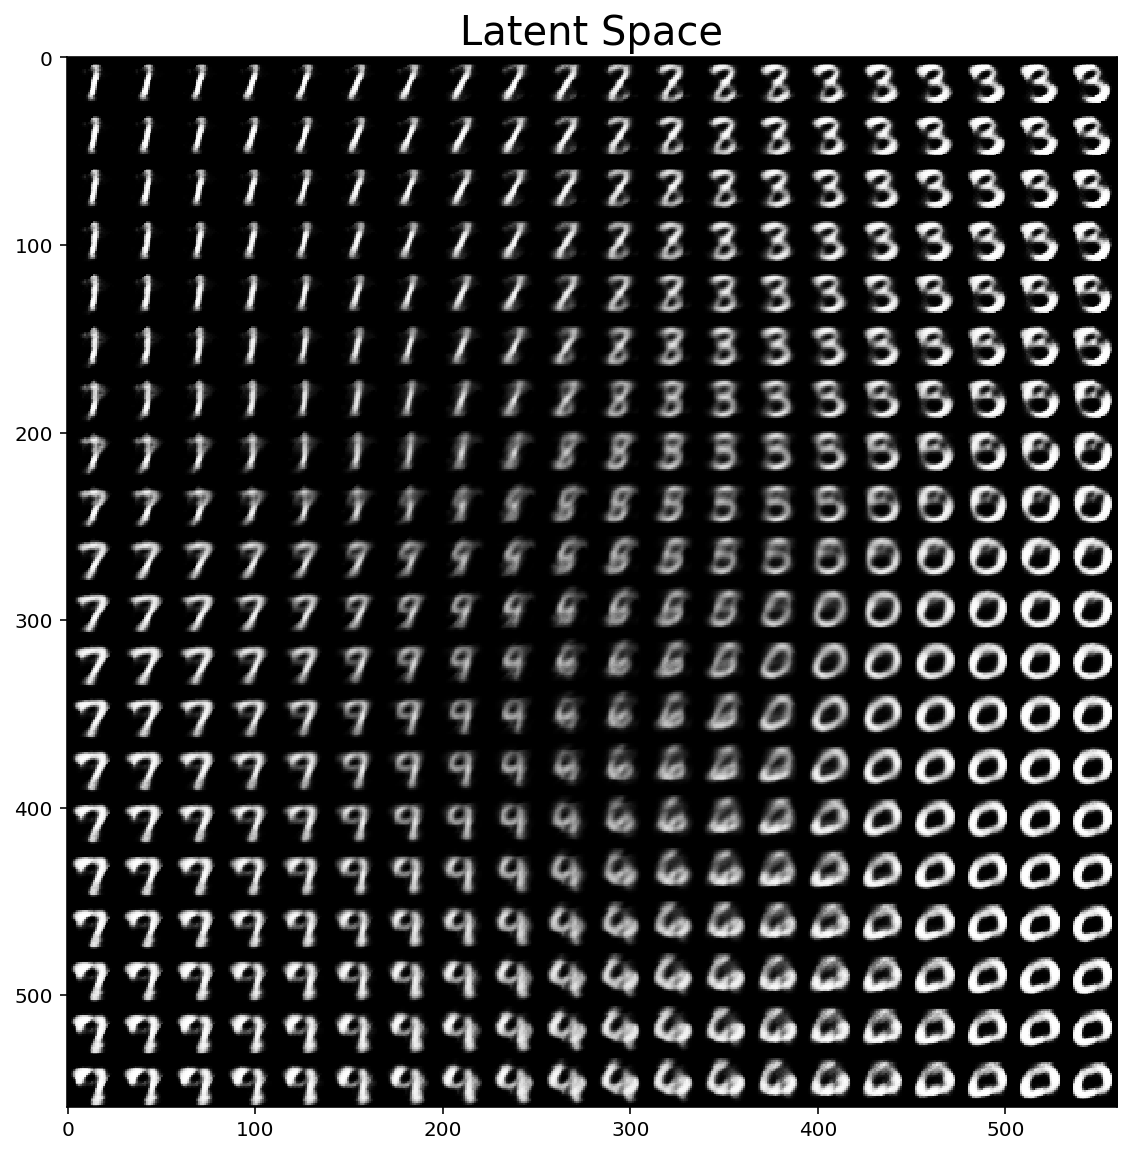

[16/50] recon:[0.294] d:[0.011] g:[0.005].
[17/50] recon:[0.294] d:[0.011] g:[0.005].
[18/50] recon:[0.294] d:[0.011] g:[0.005].
[19/50] recon:[0.294] d:[0.011] g:[0.005].
[20/50] recon:[0.293] d:[0.011] g:[0.005].


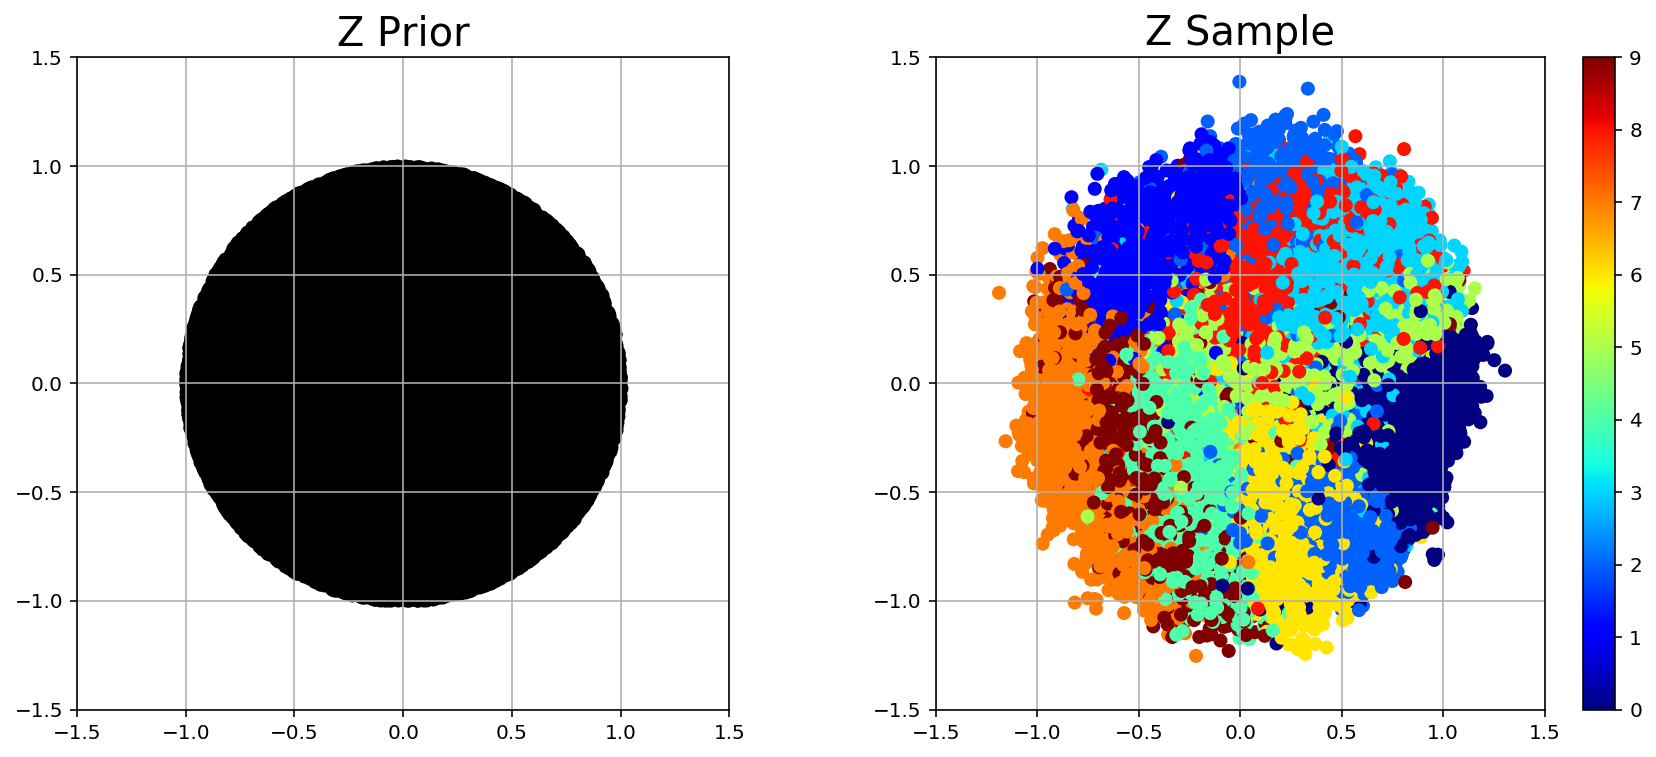

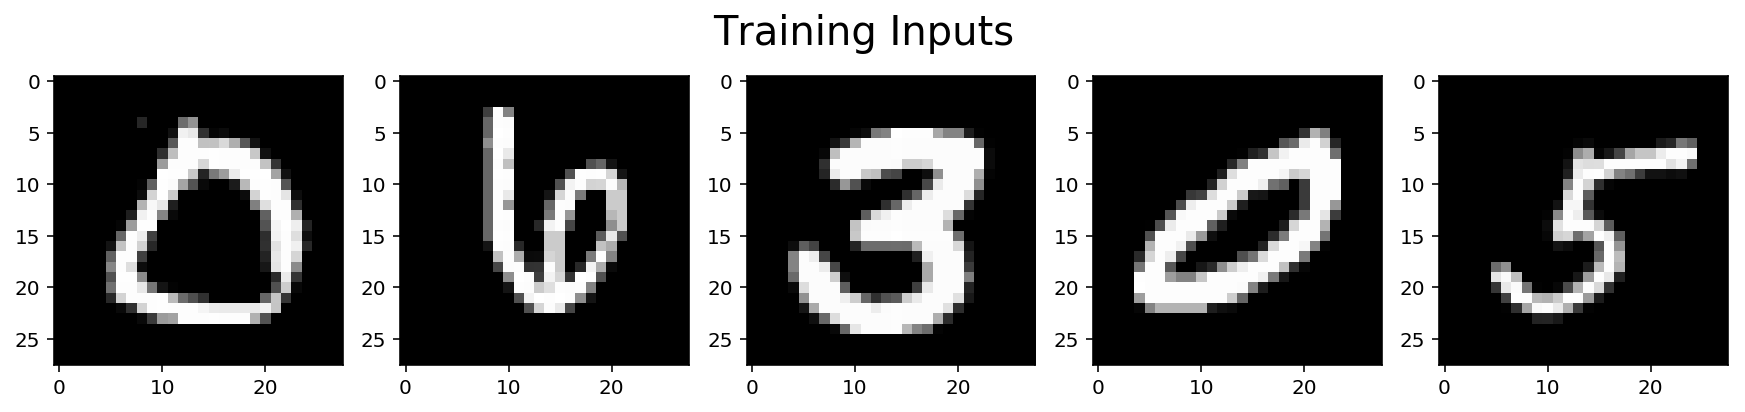

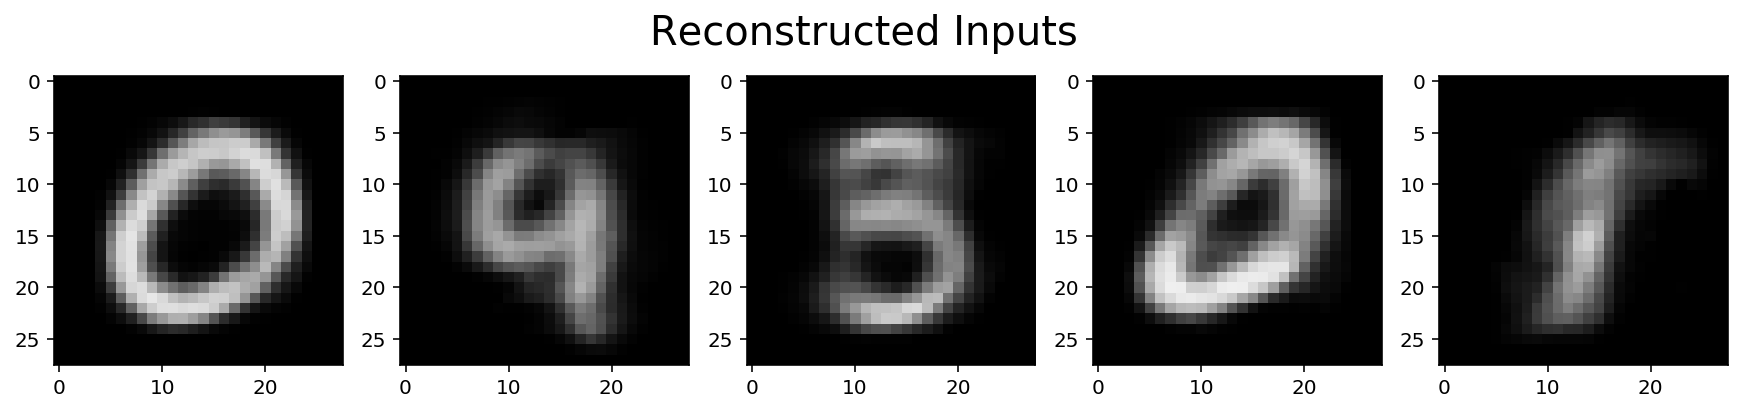

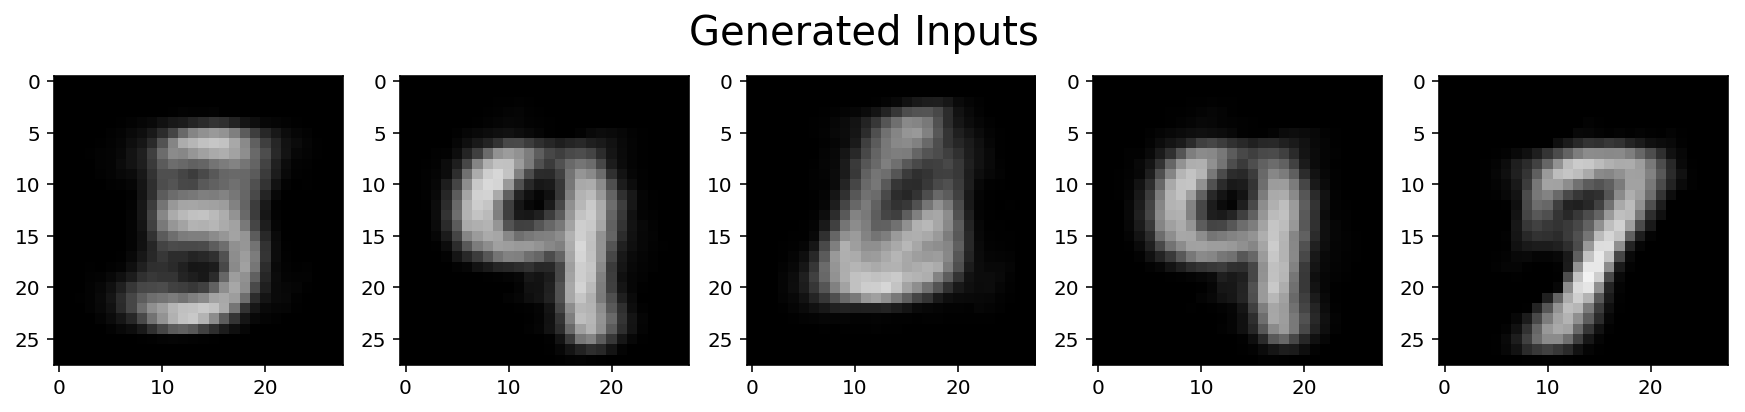

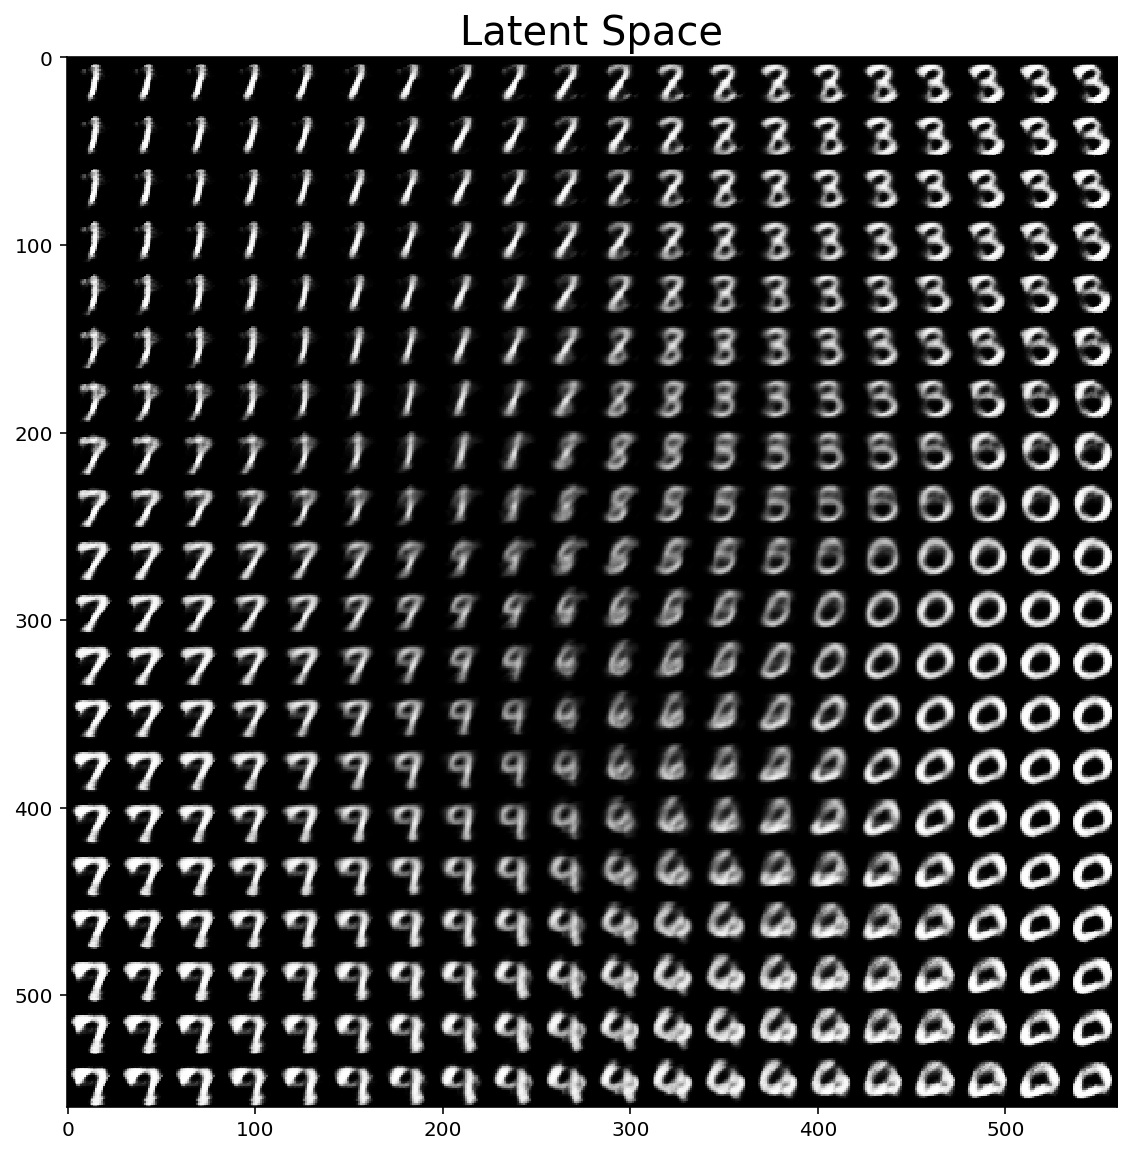

[21/50] recon:[0.292] d:[0.011] g:[0.005].
[22/50] recon:[0.292] d:[0.011] g:[0.005].
[23/50] recon:[0.291] d:[0.011] g:[0.005].
[24/50] recon:[0.292] d:[0.011] g:[0.005].
[25/50] recon:[0.291] d:[0.011] g:[0.005].


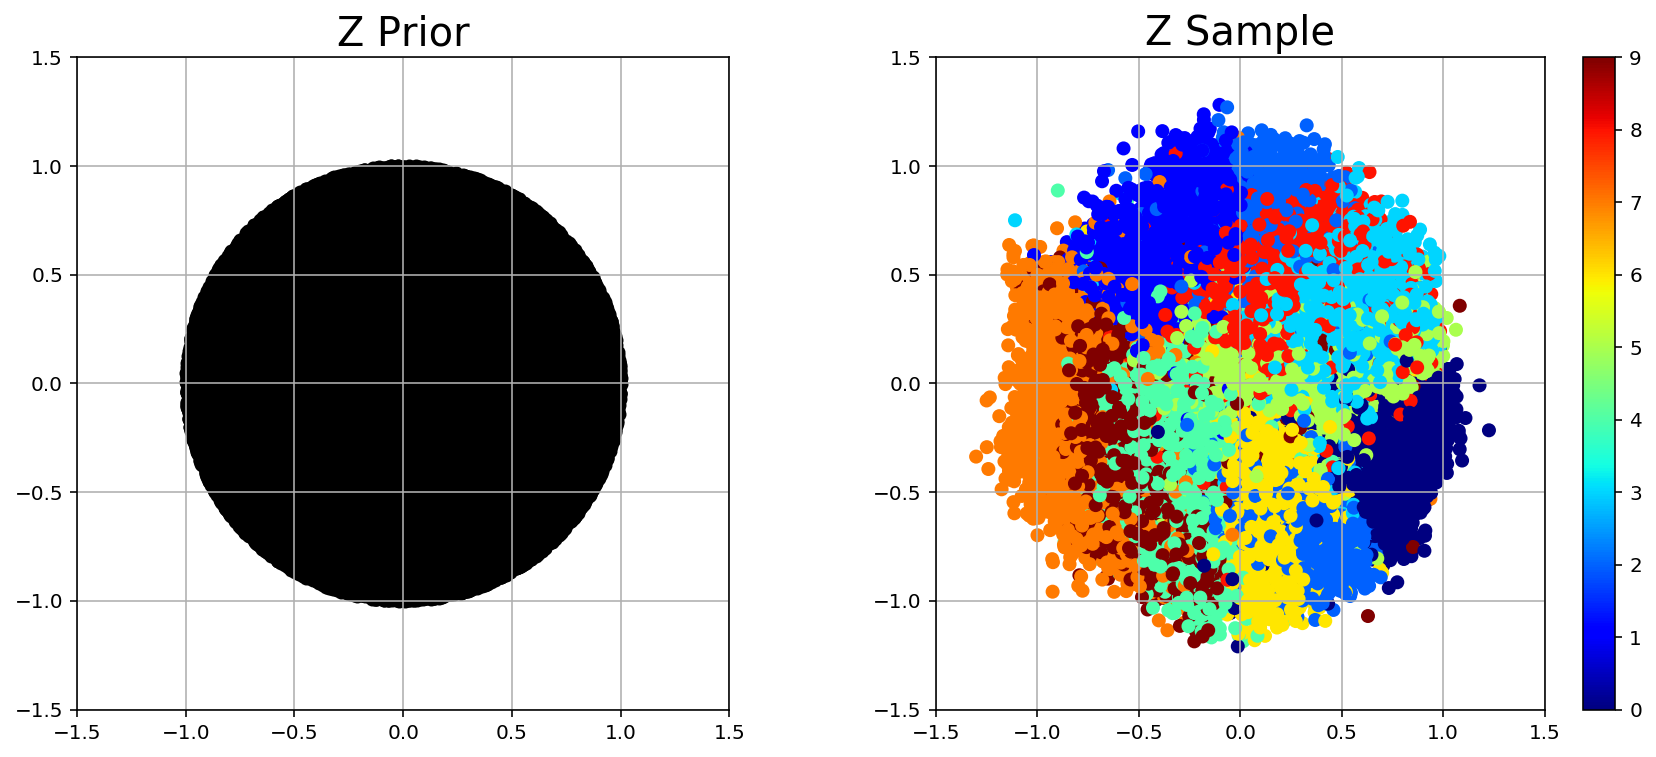

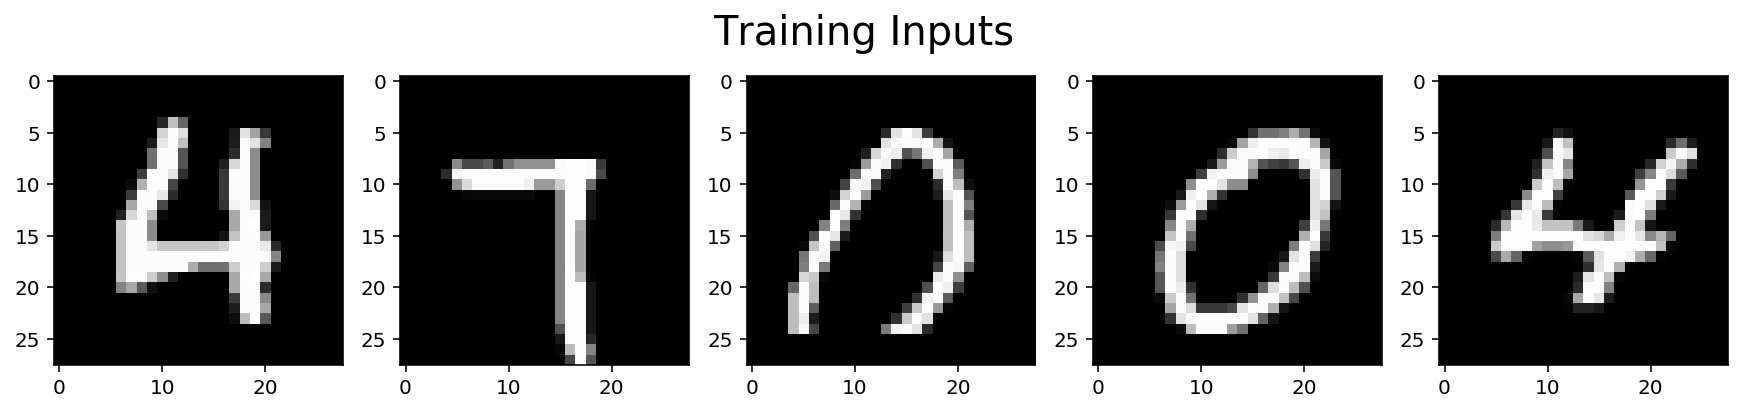

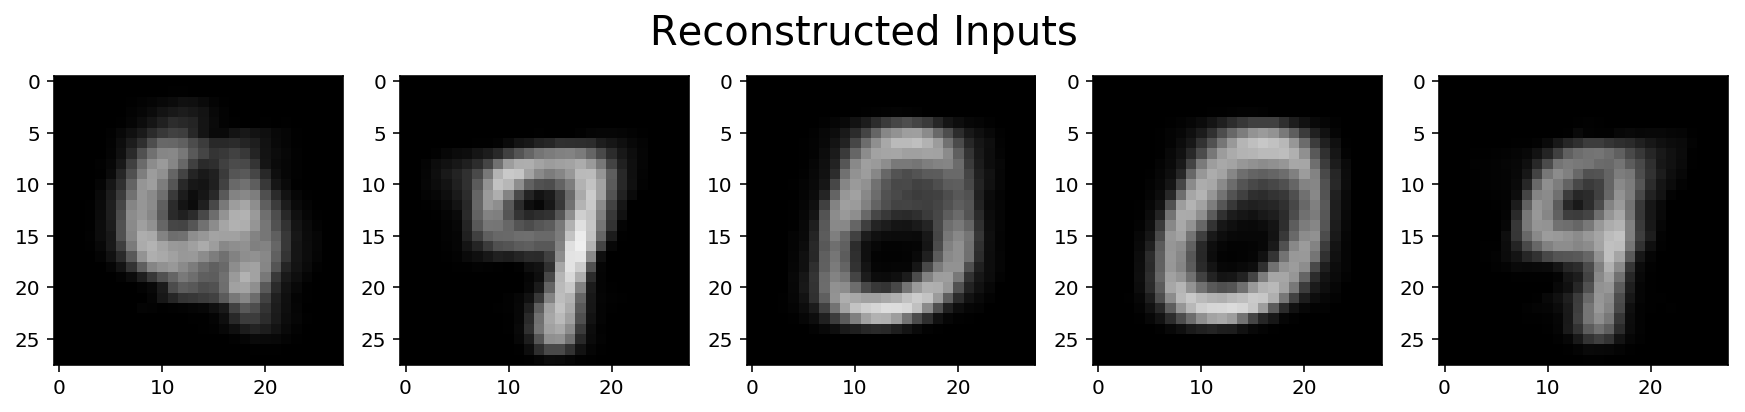

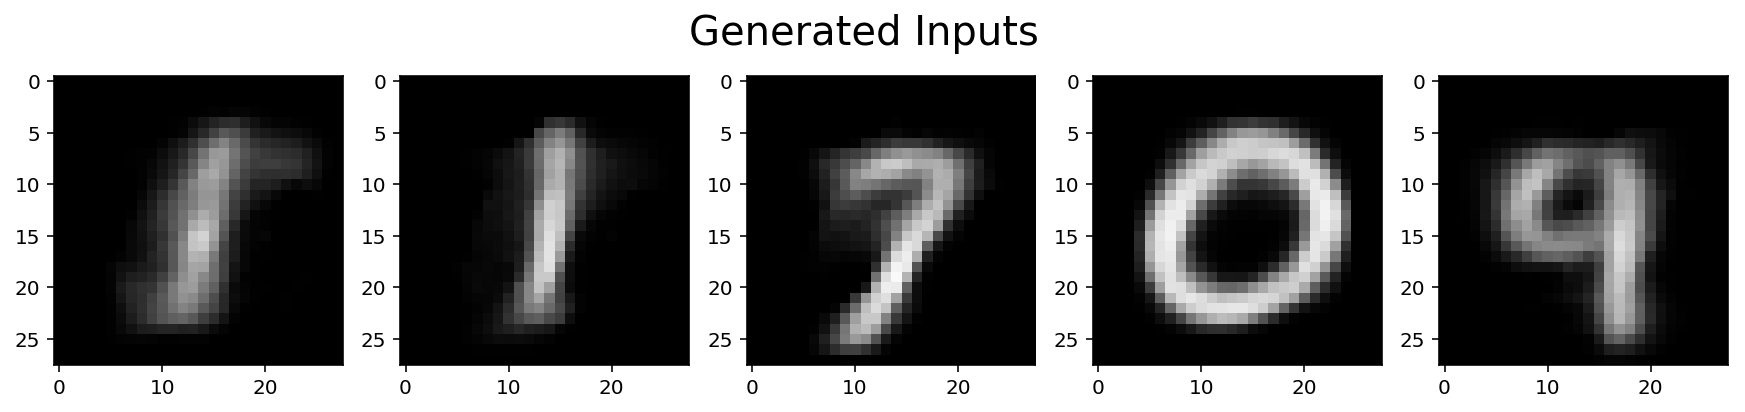

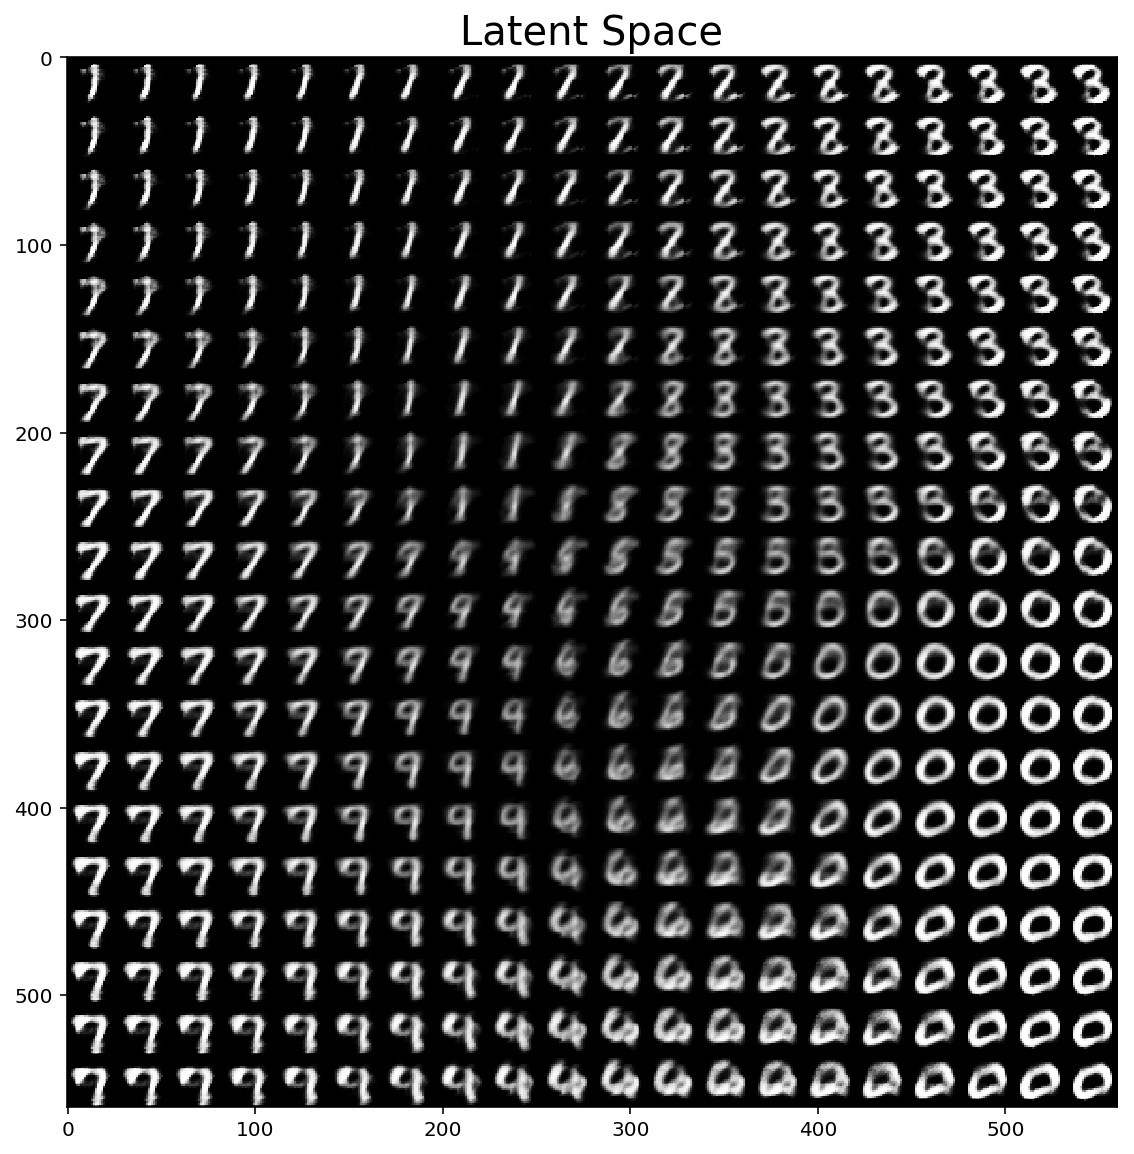

[26/50] recon:[0.291] d:[0.011] g:[0.005].
[27/50] recon:[0.291] d:[0.011] g:[0.005].
[28/50] recon:[0.291] d:[0.011] g:[0.005].
[29/50] recon:[0.291] d:[0.011] g:[0.005].
[30/50] recon:[0.292] d:[0.011] g:[0.005].


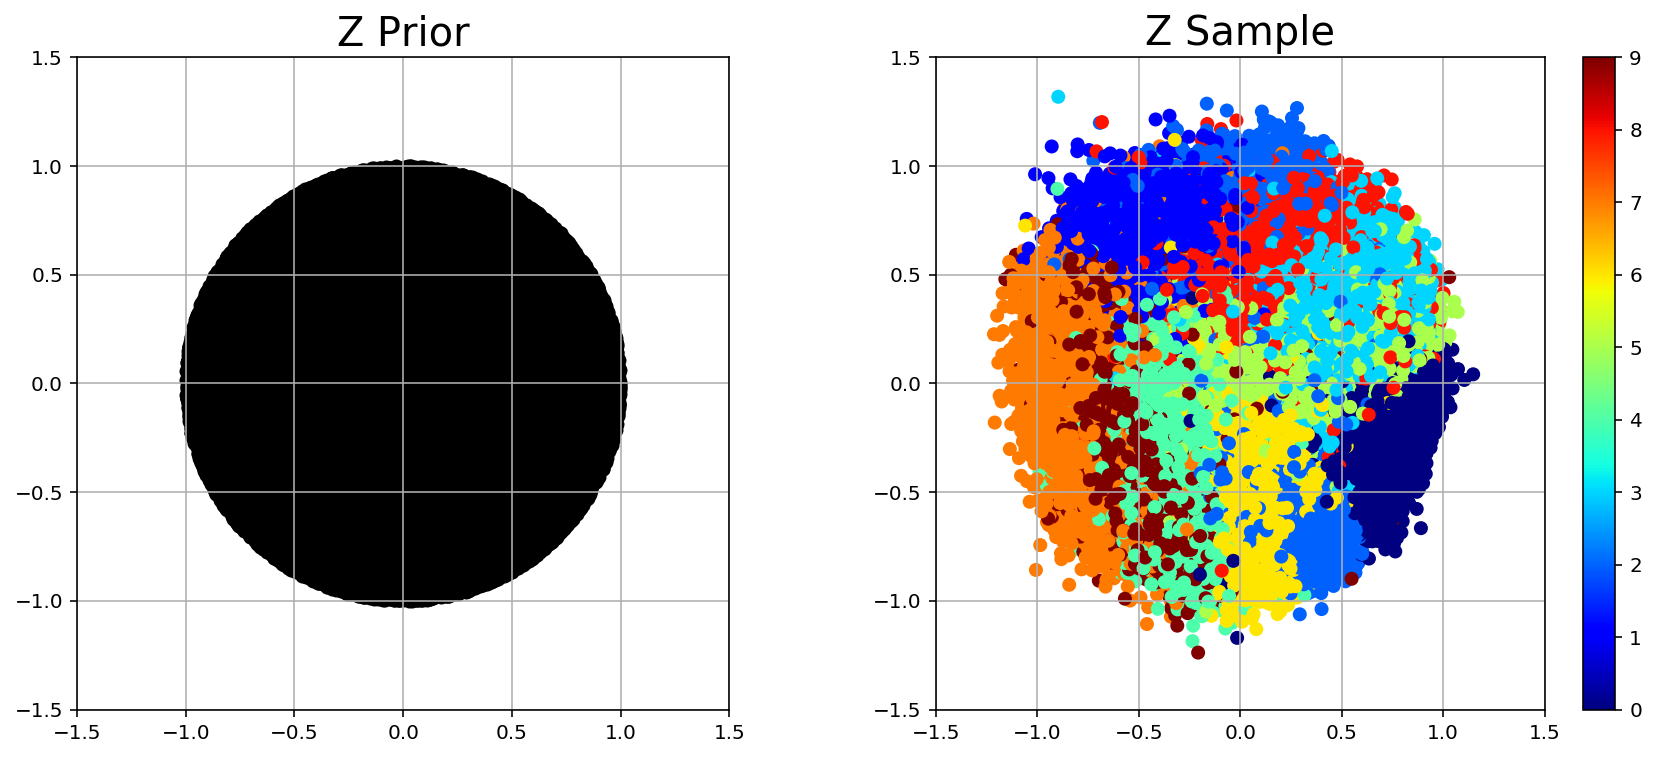

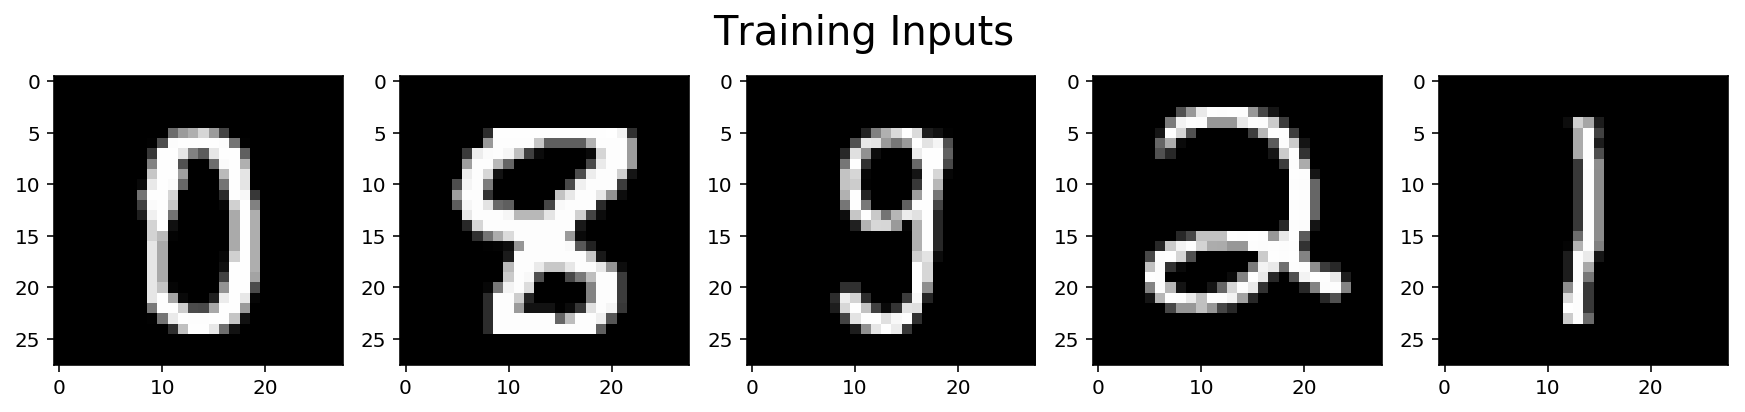

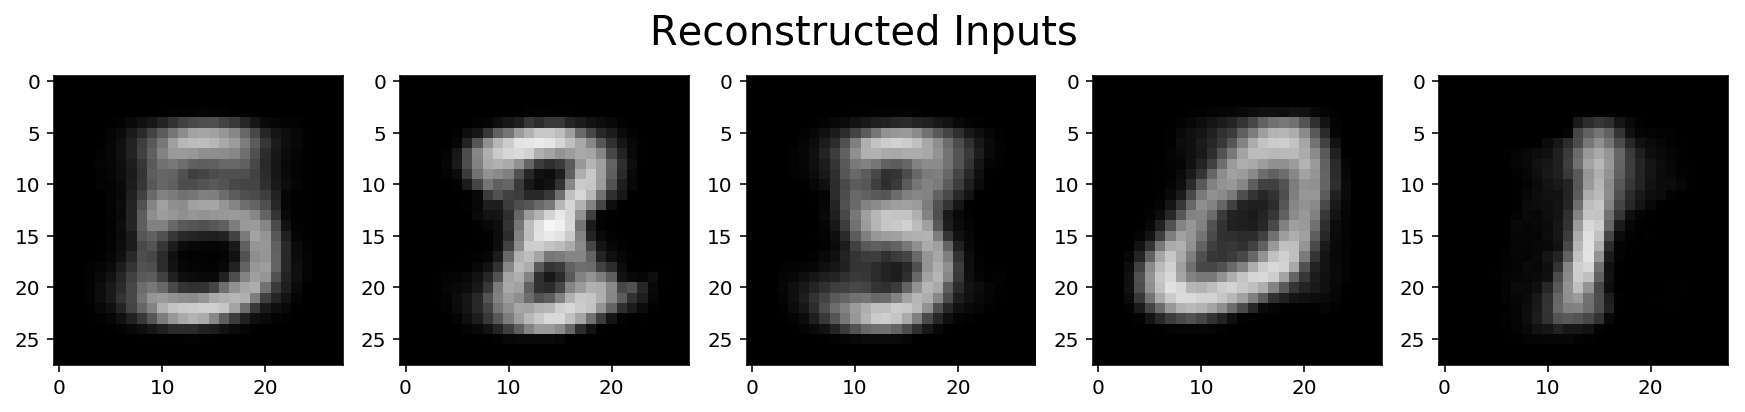

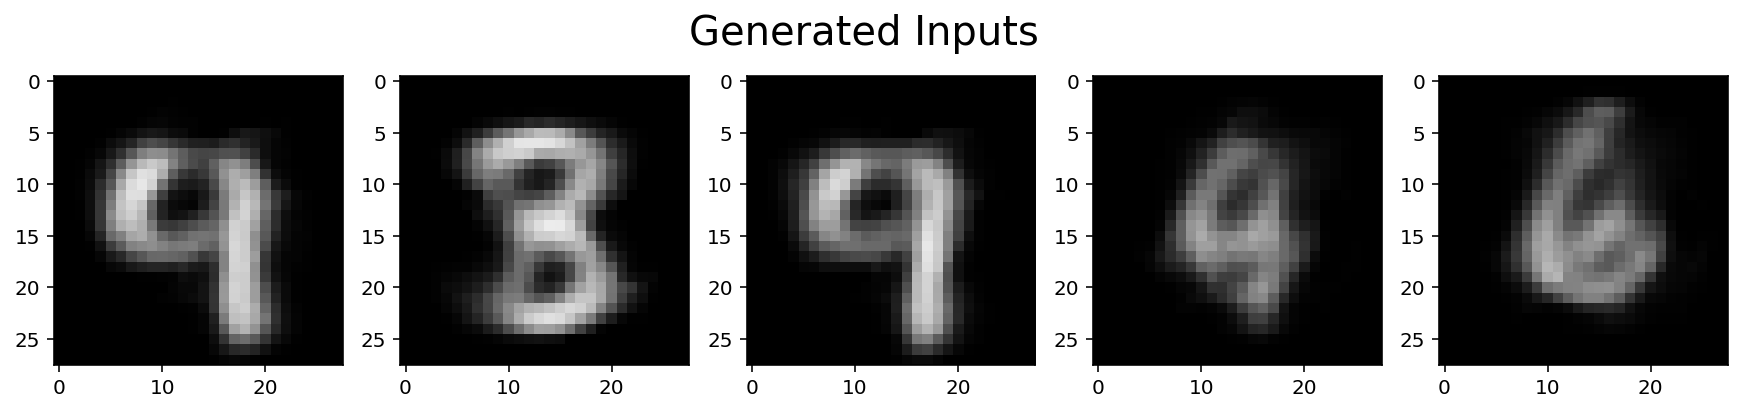

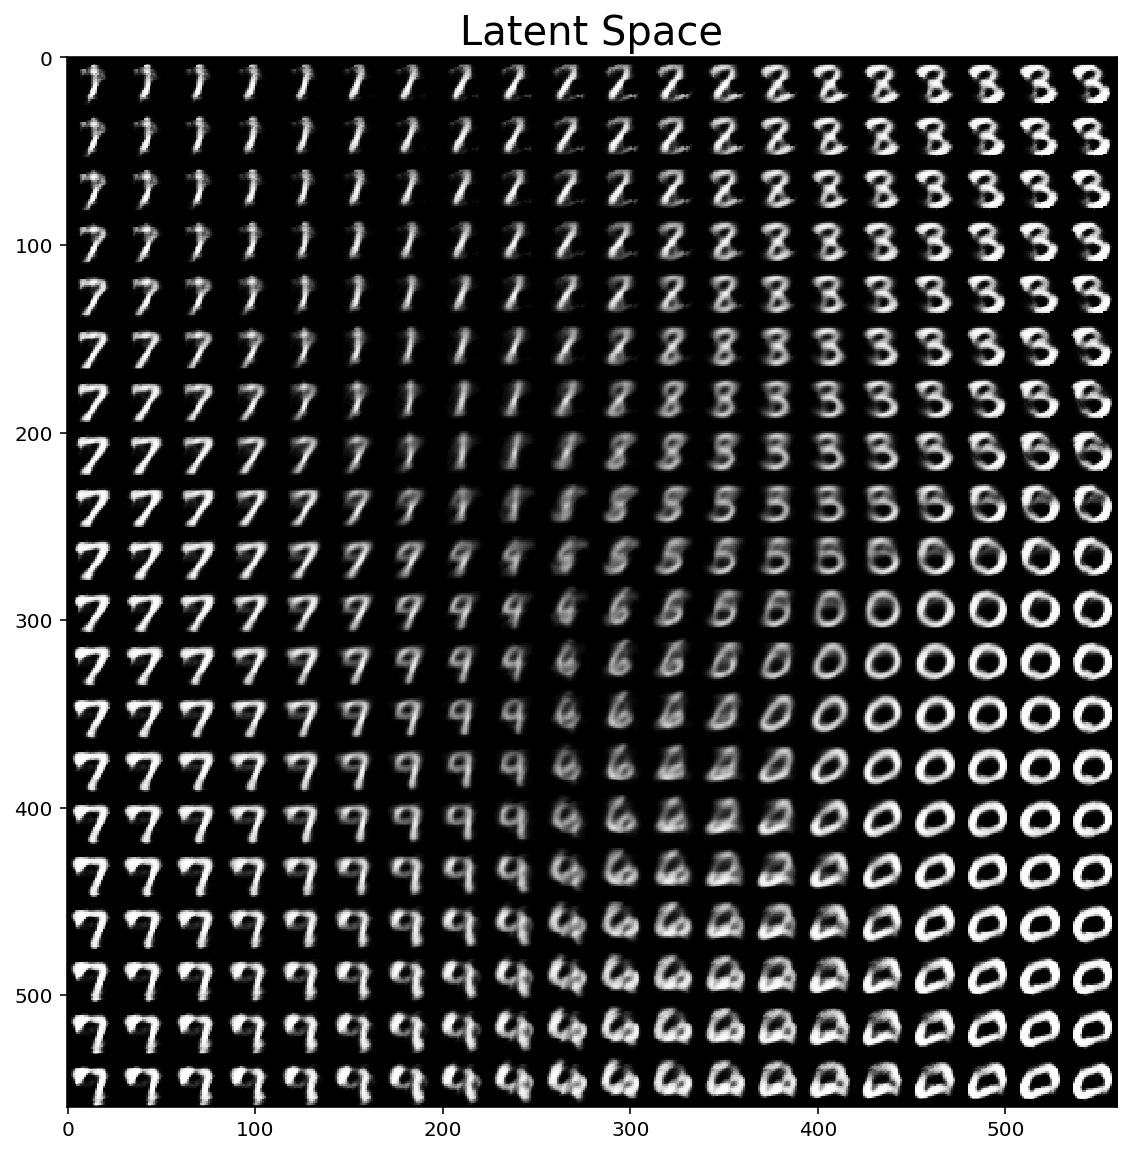

[31/50] recon:[0.293] d:[0.011] g:[0.005].
[32/50] recon:[0.293] d:[0.011] g:[0.005].
[33/50] recon:[0.293] d:[0.011] g:[0.005].
[34/50] recon:[0.292] d:[0.011] g:[0.005].
[35/50] recon:[0.292] d:[0.011] g:[0.005].


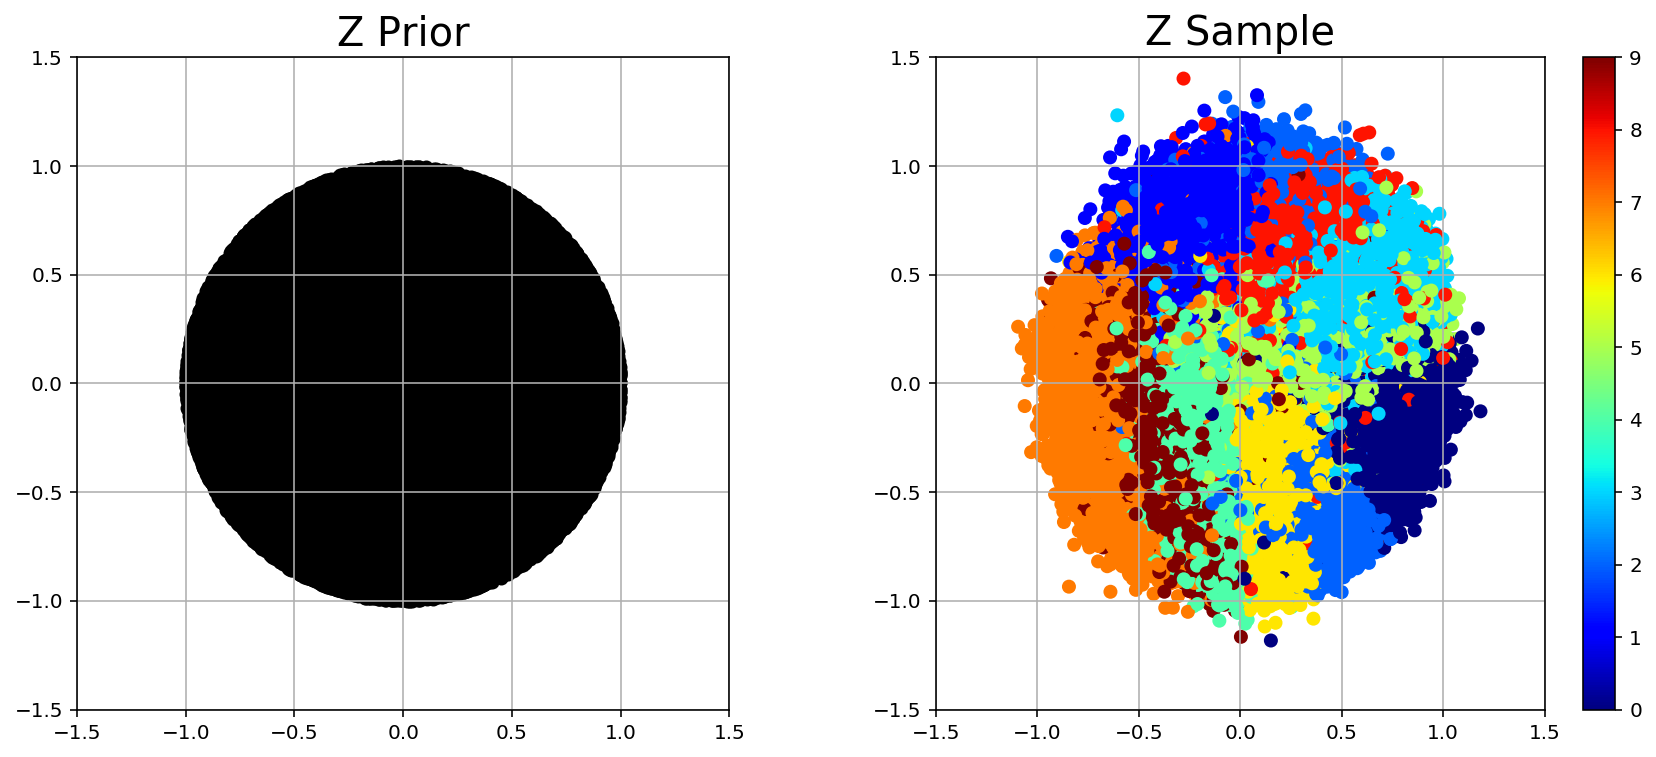

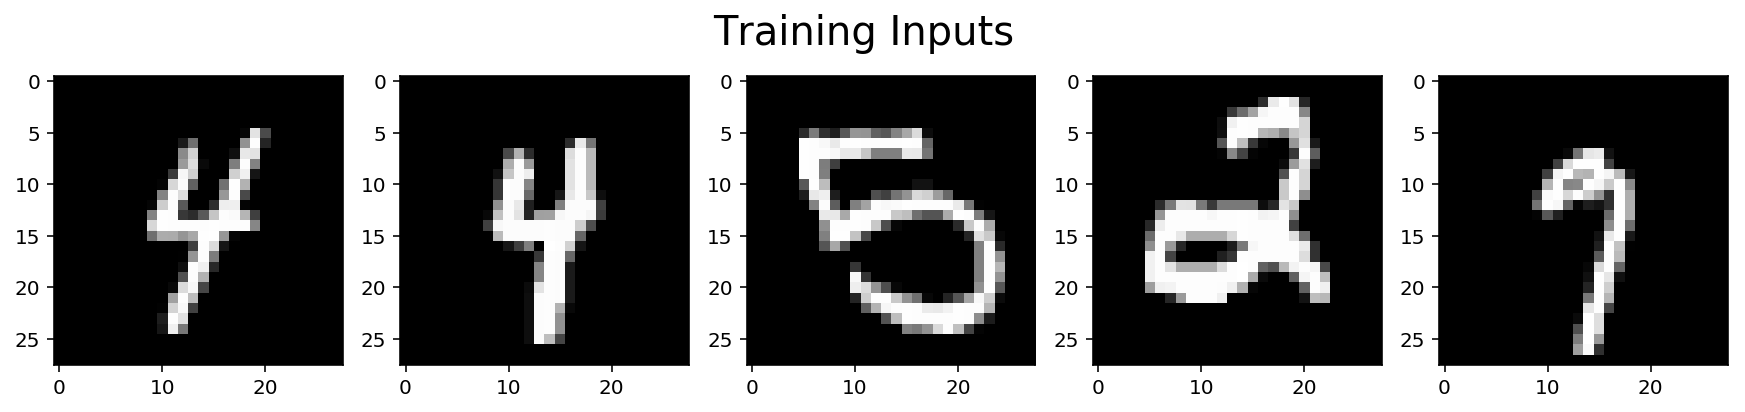

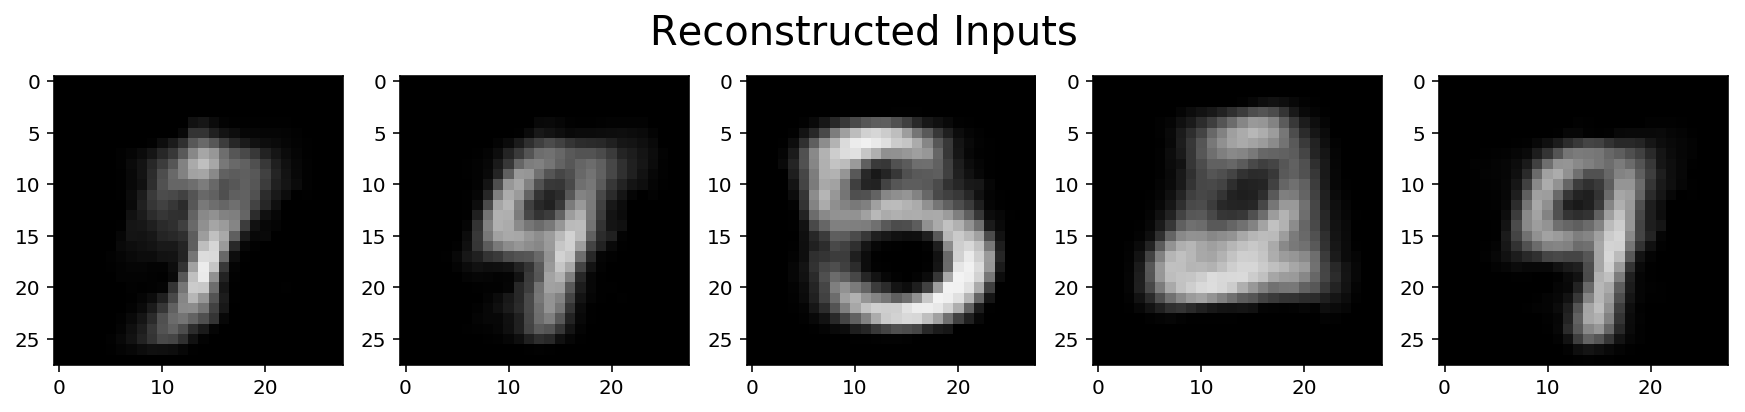

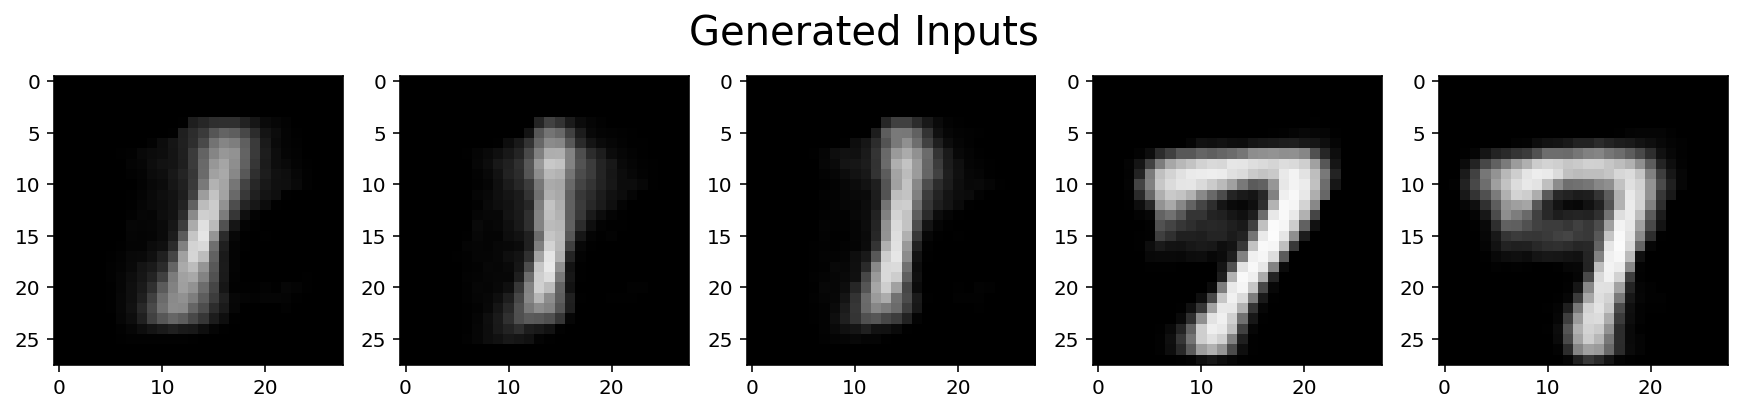

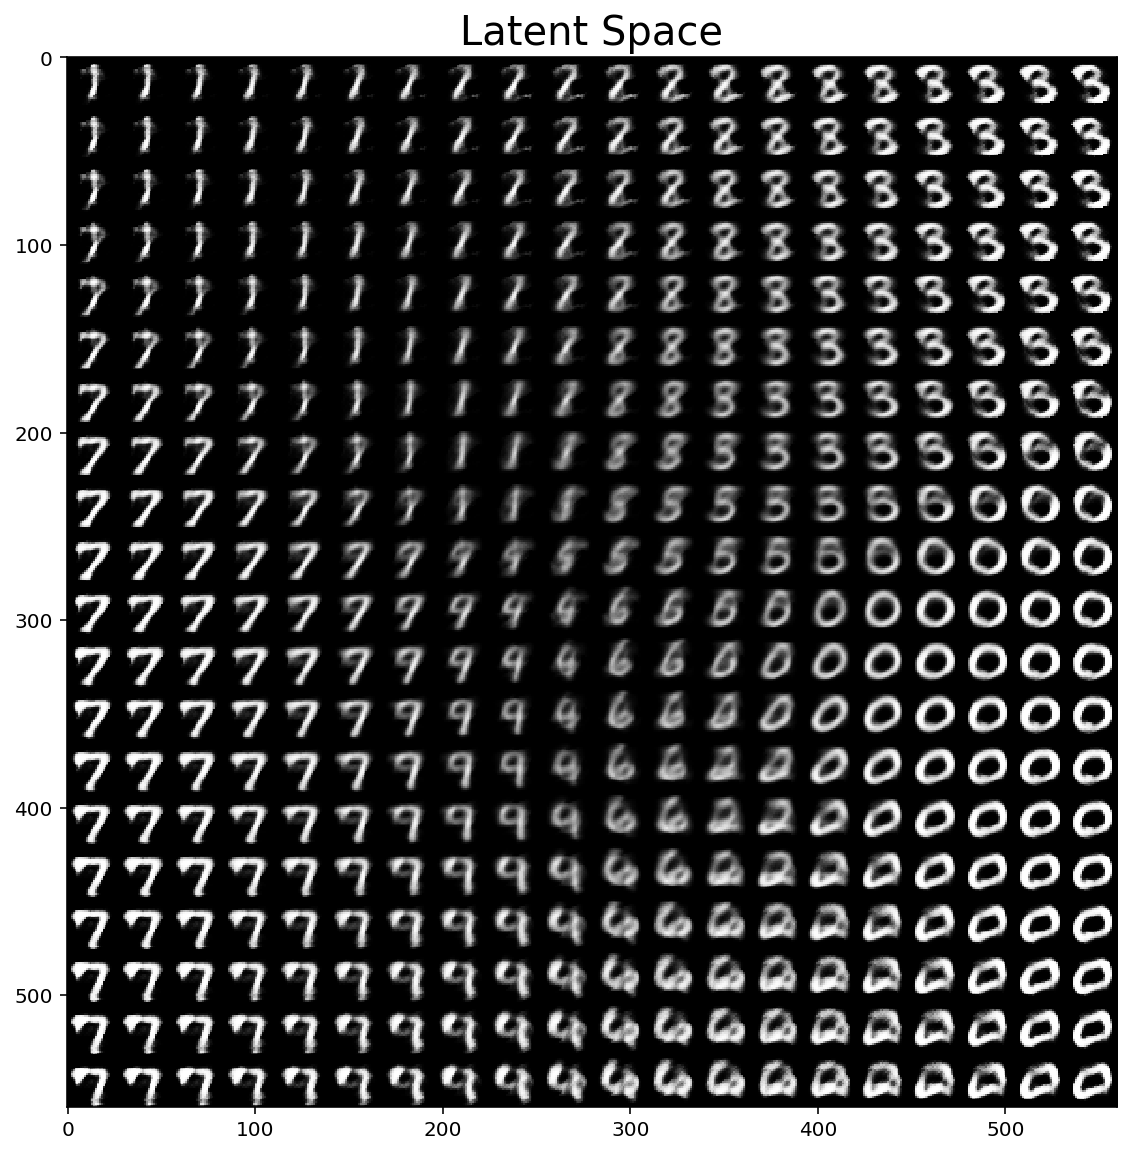

[36/50] recon:[0.292] d:[0.011] g:[0.005].
[37/50] recon:[0.290] d:[0.011] g:[0.005].
[38/50] recon:[0.290] d:[0.011] g:[0.005].
[39/50] recon:[0.290] d:[0.011] g:[0.005].
[40/50] recon:[0.291] d:[0.011] g:[0.005].


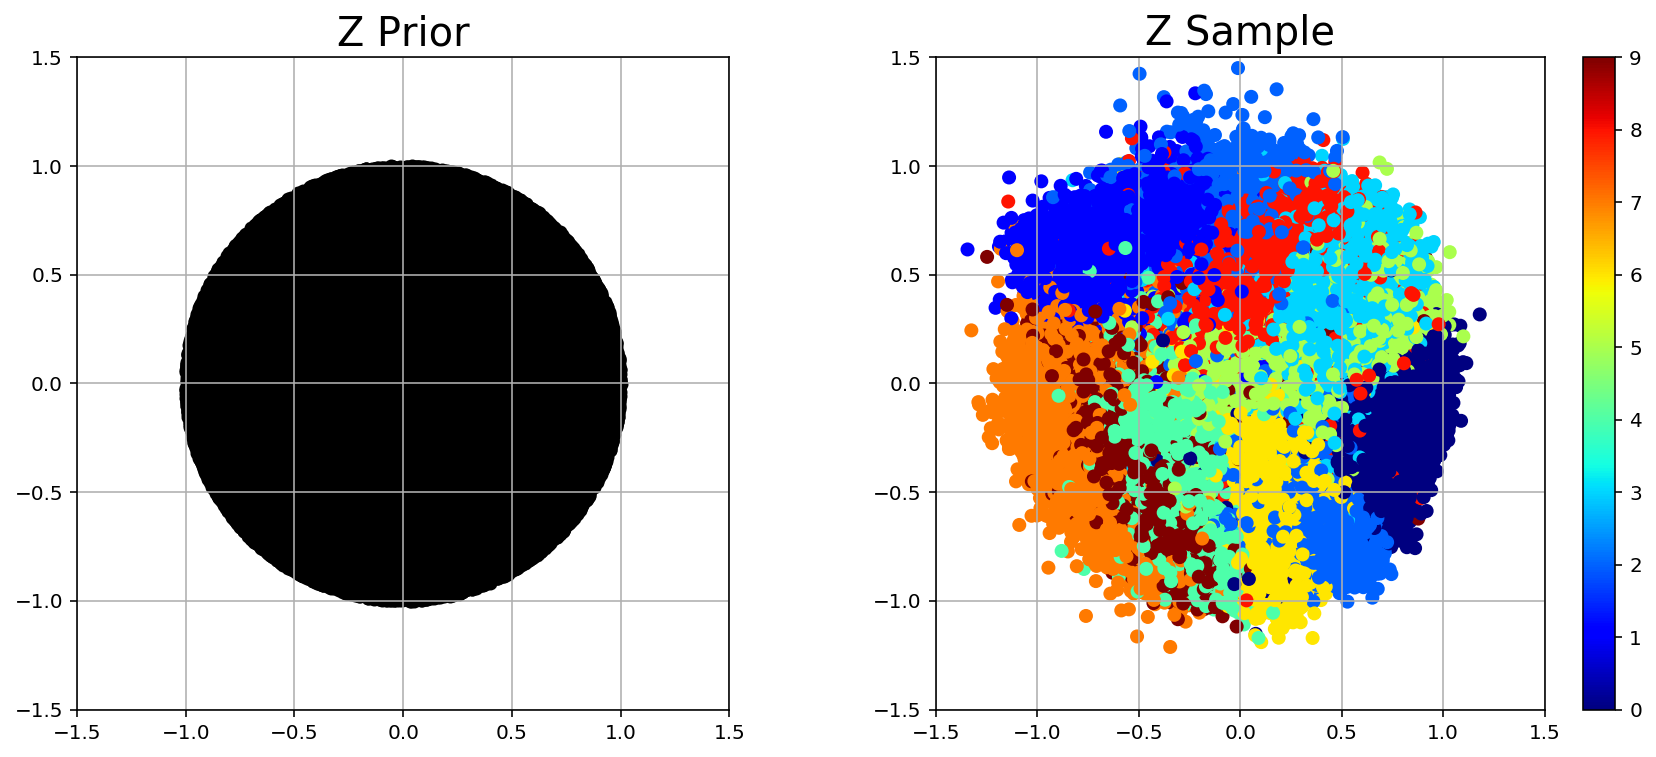

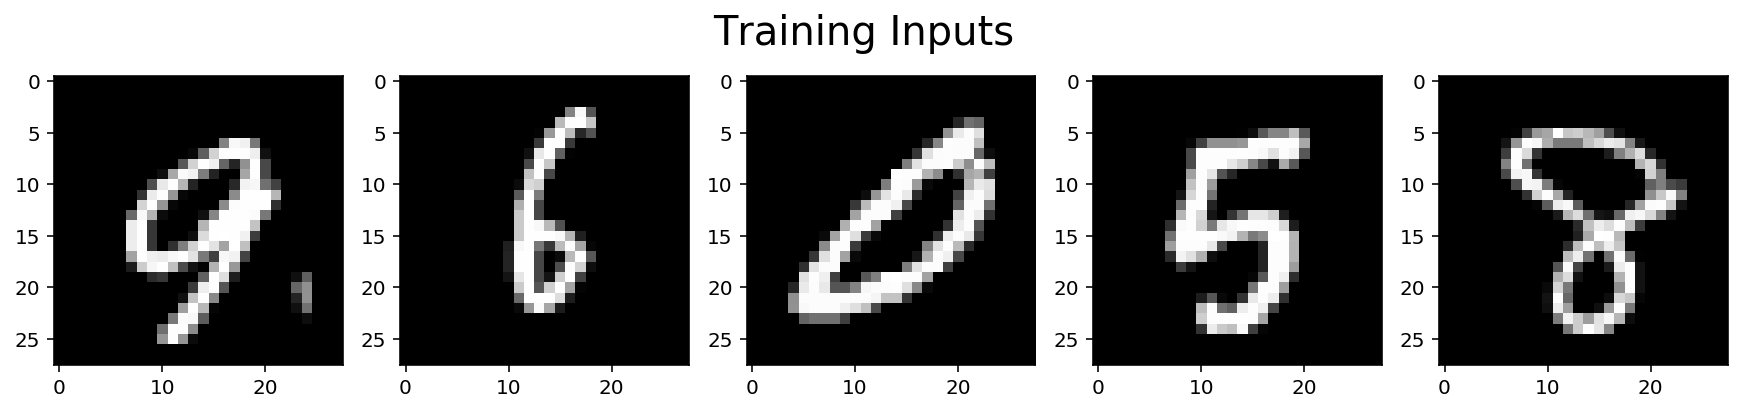

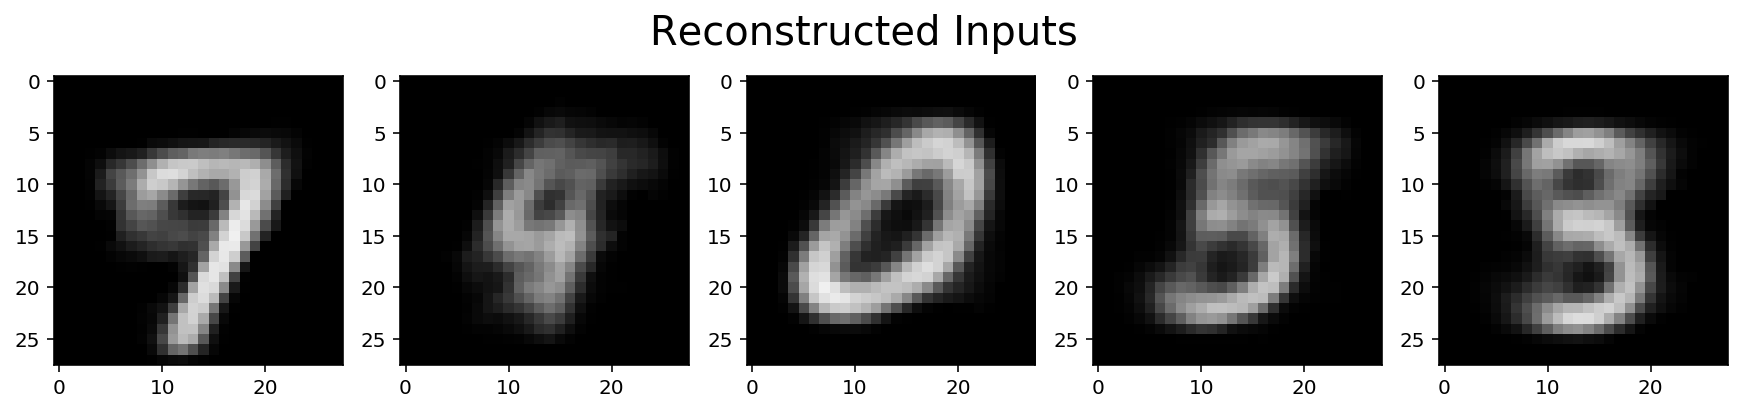

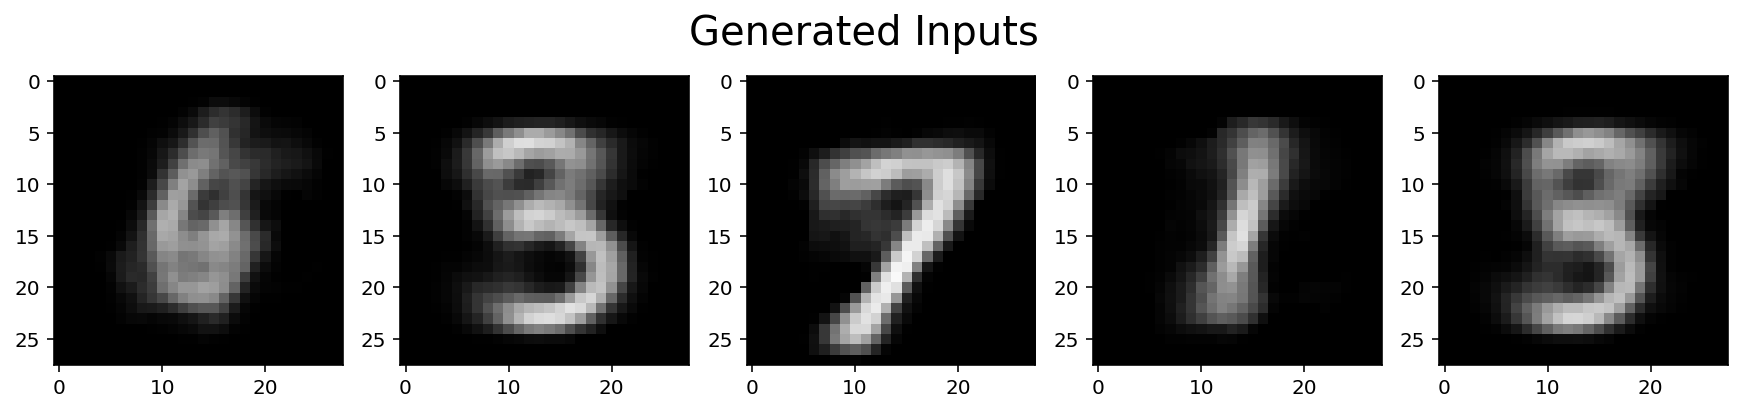

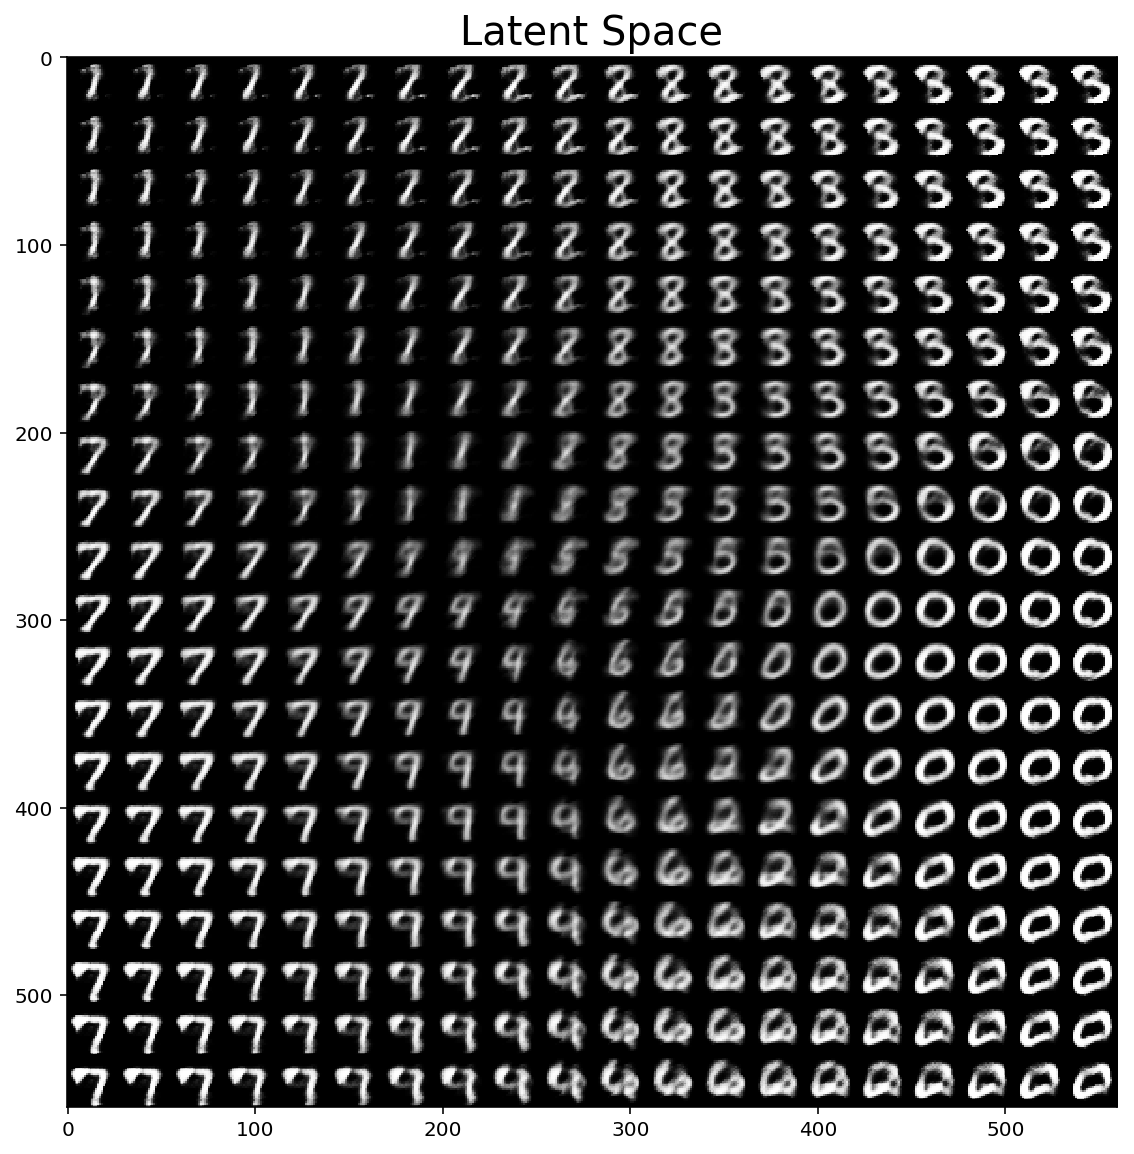

[41/50] recon:[0.291] d:[0.011] g:[0.005].
[42/50] recon:[0.291] d:[0.011] g:[0.005].
[43/50] recon:[0.291] d:[0.011] g:[0.005].
[44/50] recon:[0.290] d:[0.011] g:[0.005].
[45/50] recon:[0.291] d:[0.011] g:[0.005].


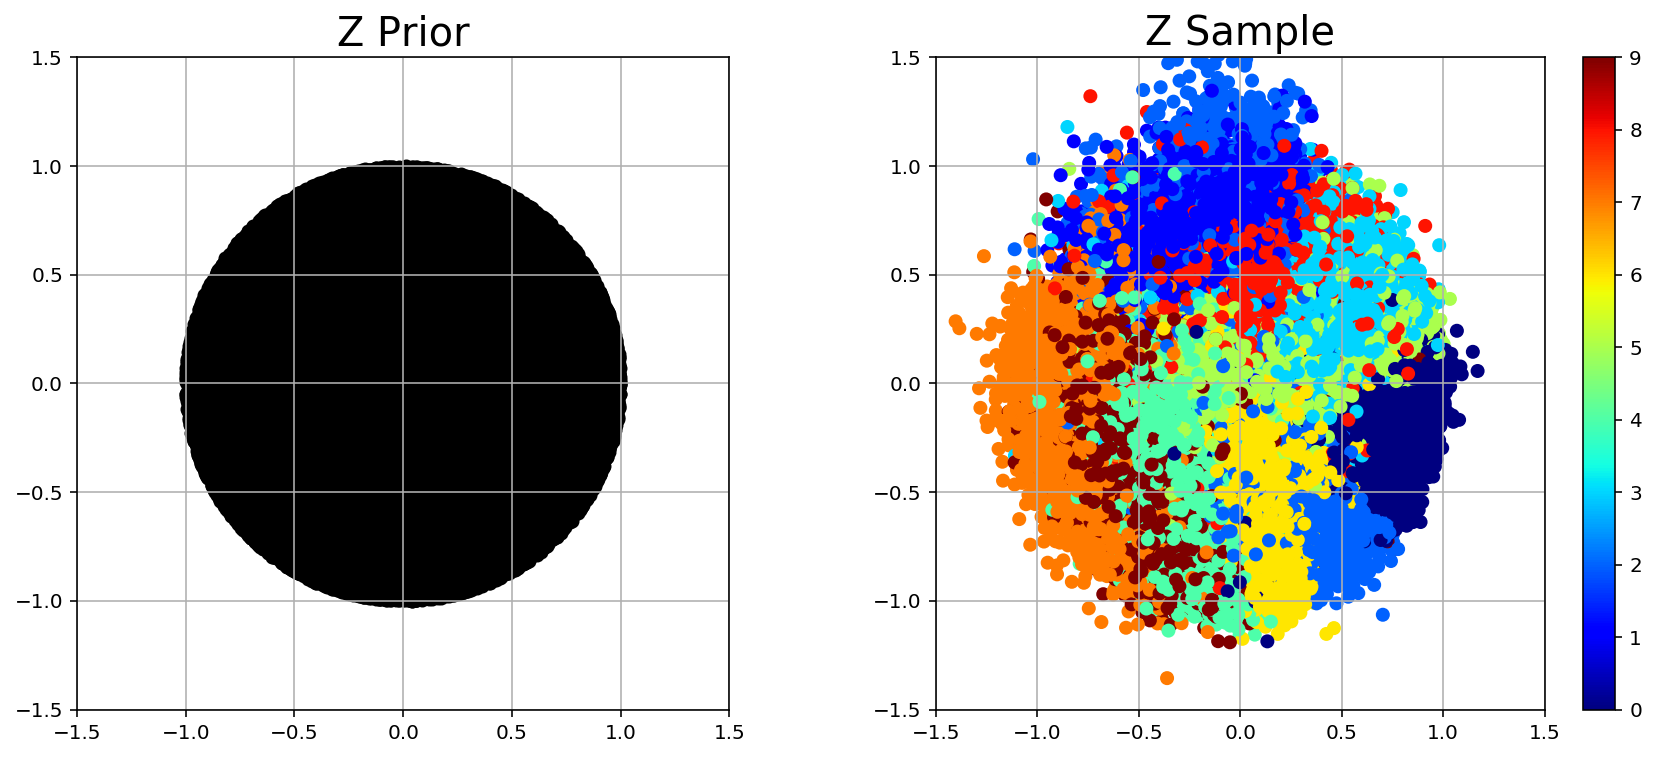

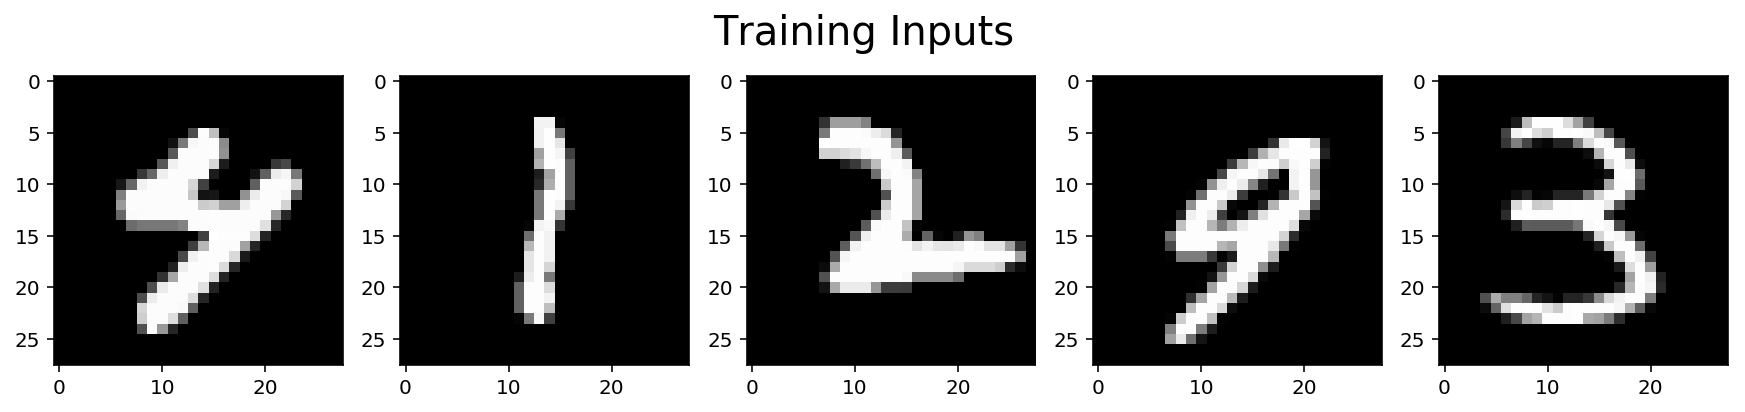

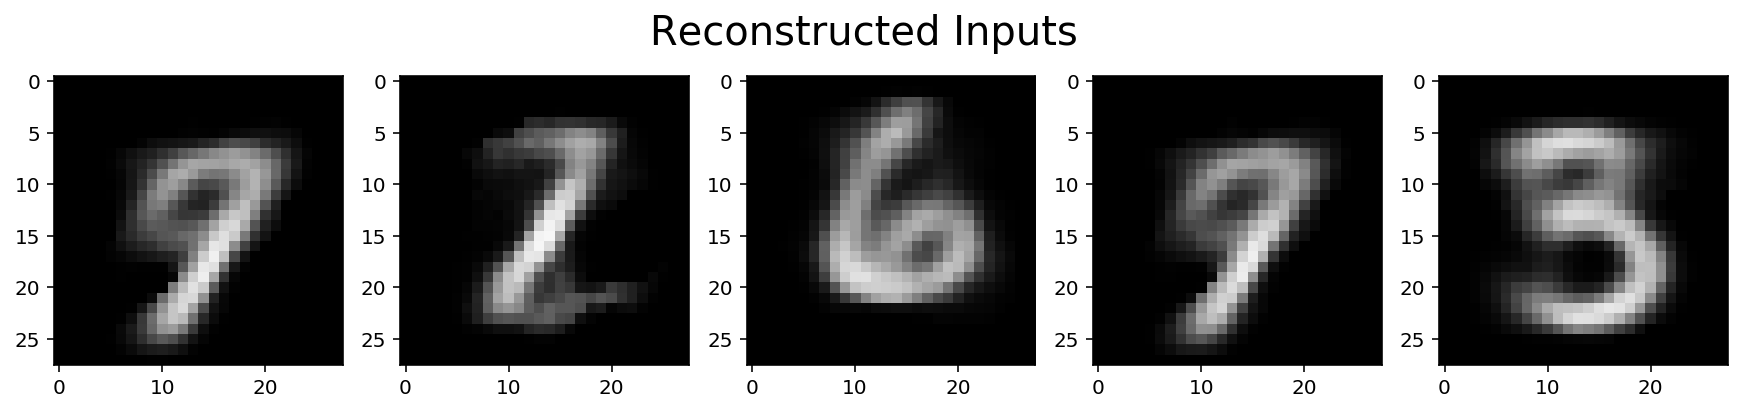

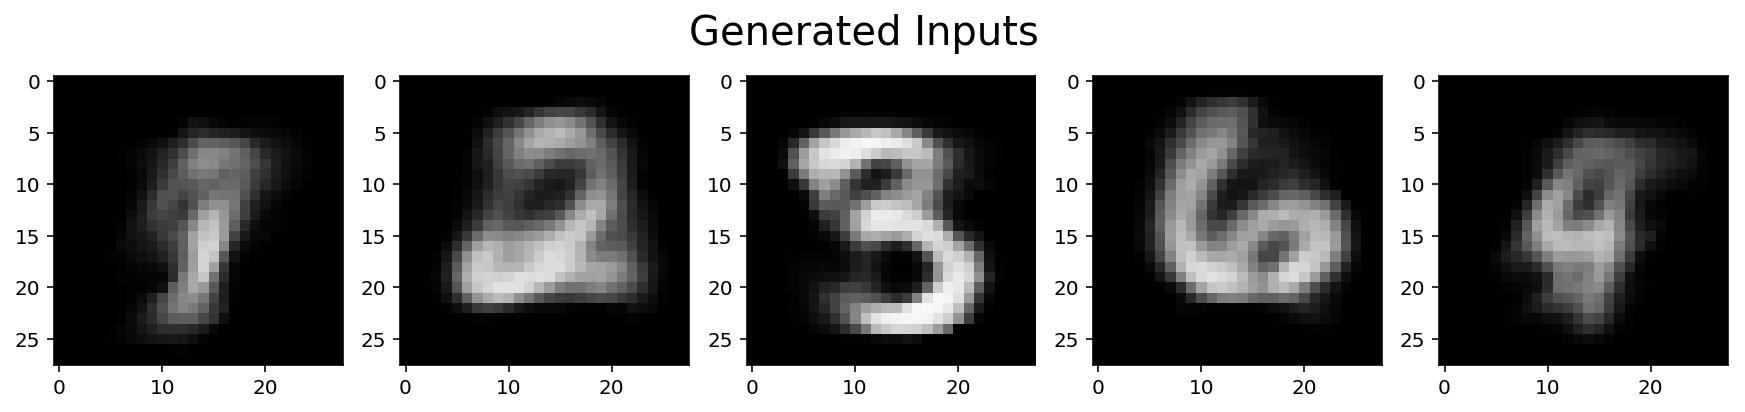

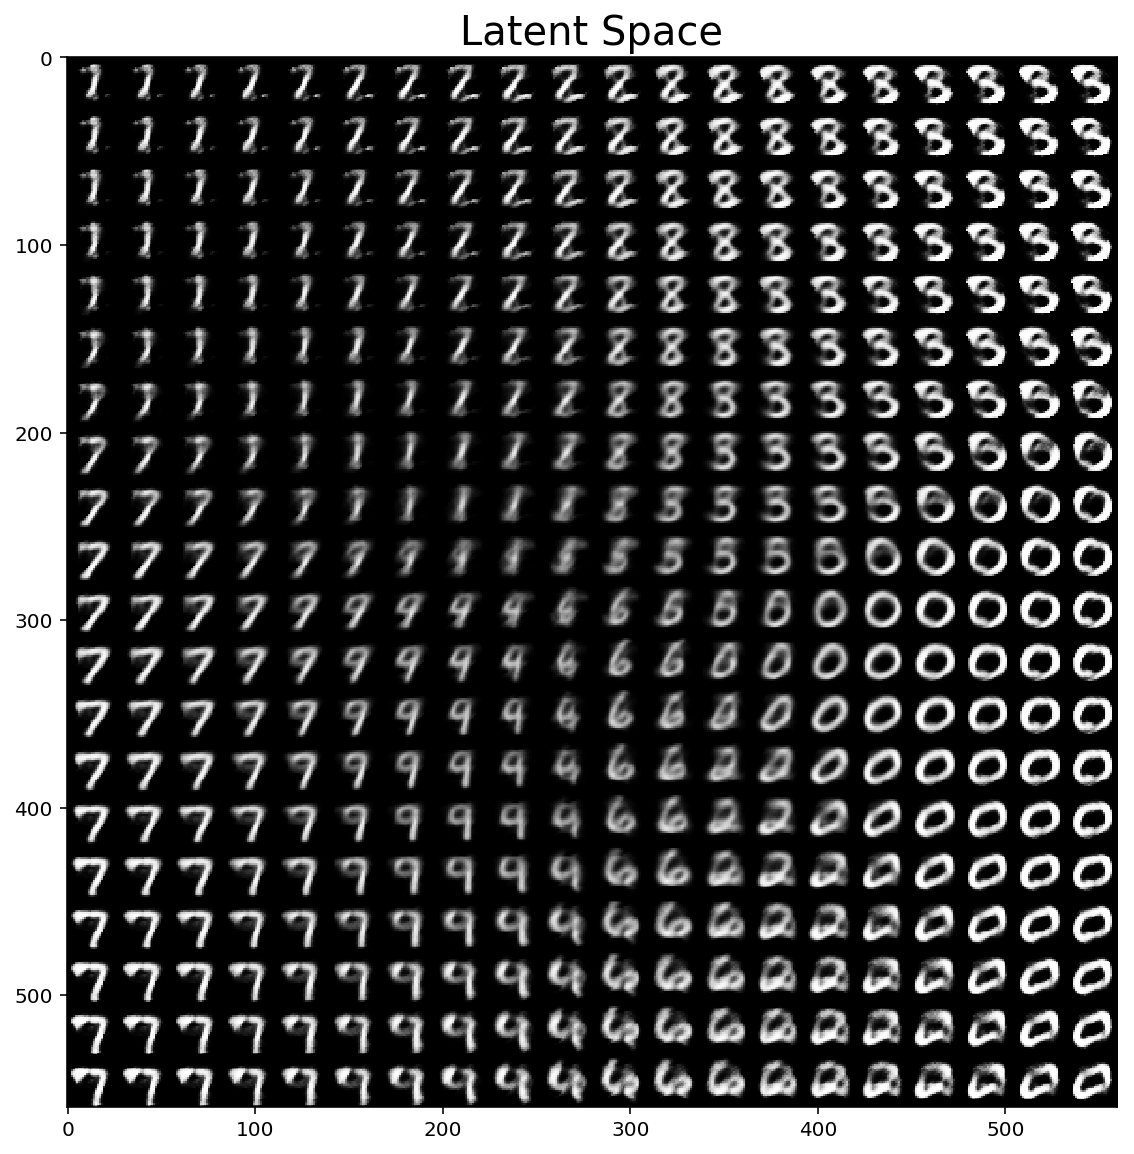

[46/50] recon:[0.292] d:[0.011] g:[0.005].
[47/50] recon:[0.293] d:[0.011] g:[0.005].
[48/50] recon:[0.294] d:[0.011] g:[0.005].
[49/50] recon:[0.295] d:[0.011] g:[0.005].


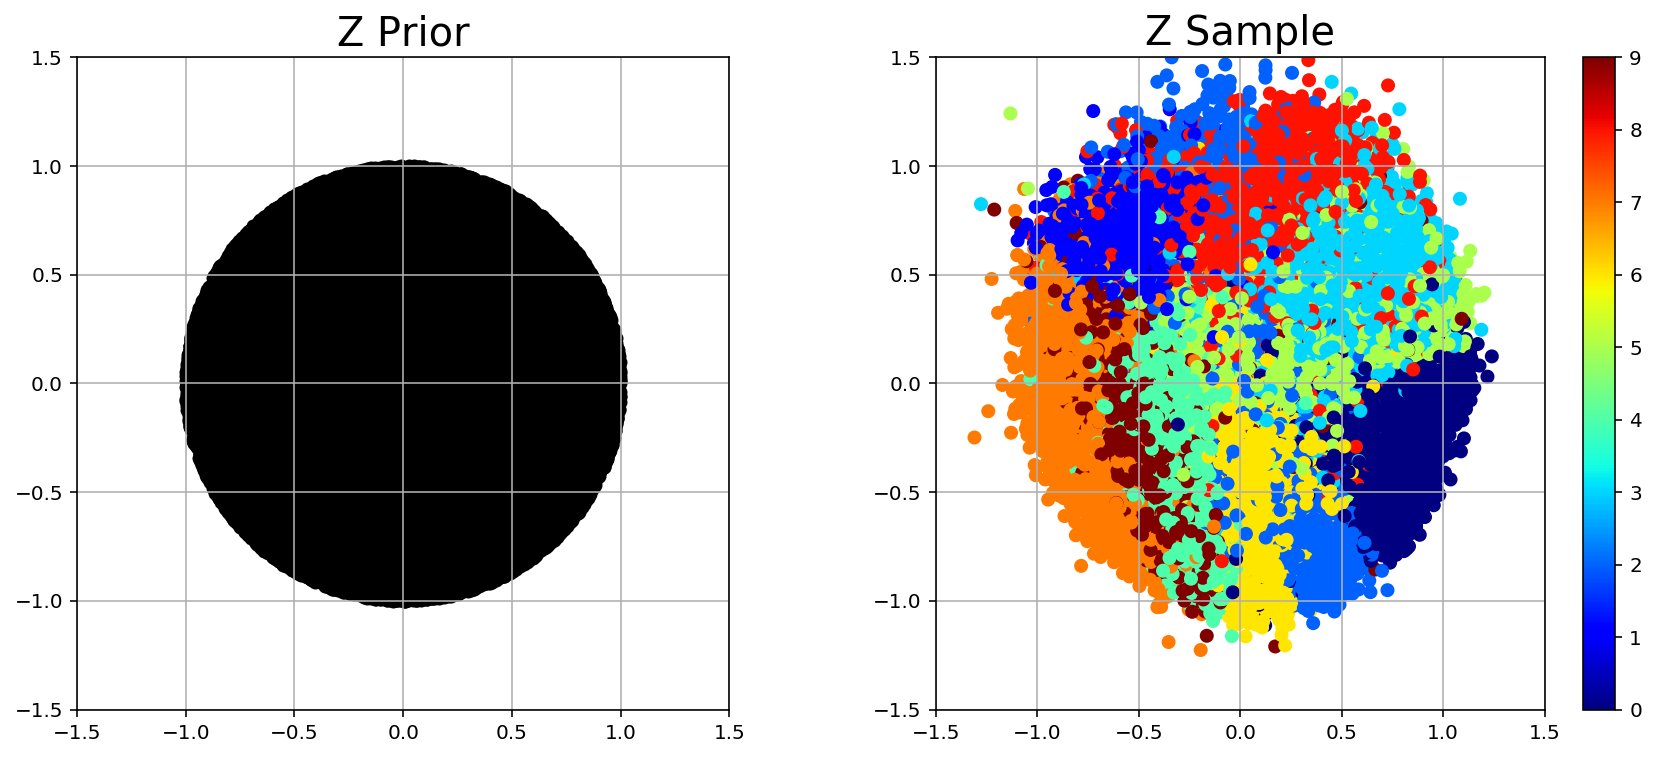

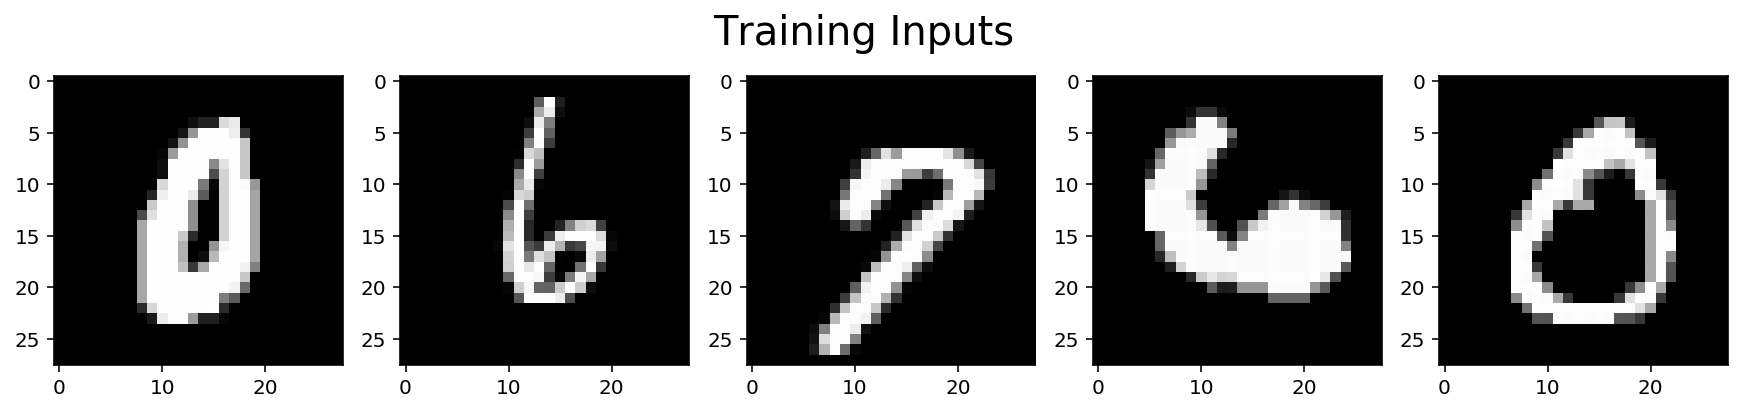

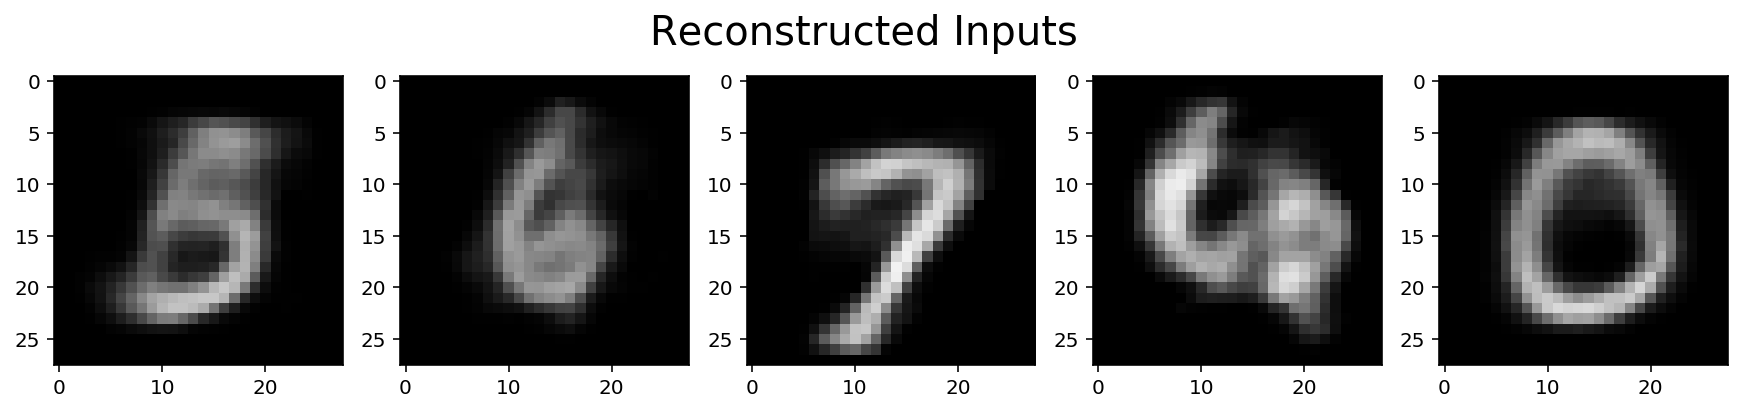

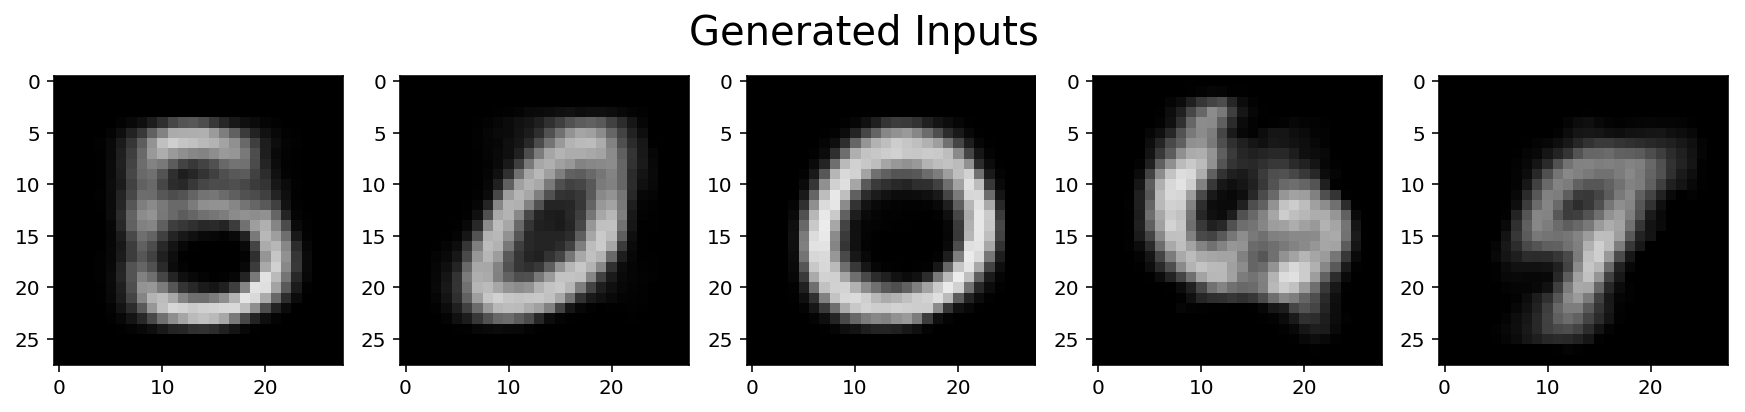

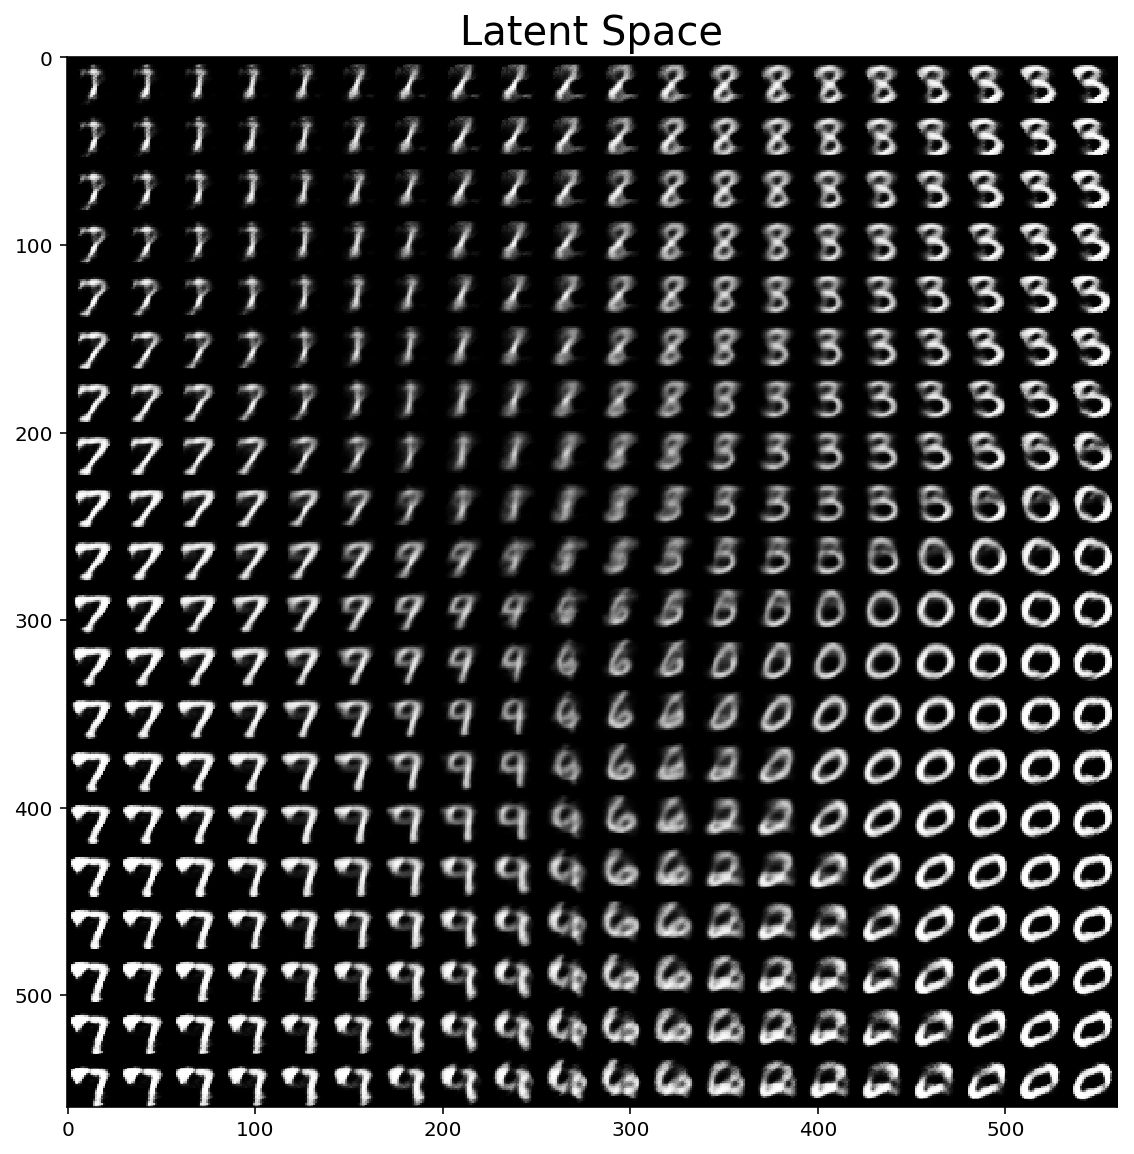

Done.


In [9]:
sess.run(tf.global_variables_initializer())
n_epoch,batch_size,plot_every = 50,128,5
for e in range(n_epoch):
    randperm_idxs = np.random.permutation(n)
    recon_loss_val_sum,d_loss_val_sum,g_loss_val_sum = 0.0,0.0,0.0
    for it in range(n//batch_size):
        batch_idx = randperm_idxs[it*batch_size:(it+1)*batch_size]
        x_batch = x[batch_idx,:]
        recon_loss_val,d_loss_val,g_loss_val = W.update(
            sess,x_batch=x_batch,
            n_g_update=1,lr=0.0002,lr_d_weight=0.1,lr_g_weight=1.0)
        recon_loss_val_sum += recon_loss_val
        d_loss_val_sum += d_loss_val
        g_loss_val_sum += g_loss_val
    recon_loss_val_avg,d_loss_val_avg,g_loss_val_avg = recon_loss_val_sum/n,d_loss_val_sum/n,g_loss_val_sum/n
    print ("[%d/%d] recon:[%.3f] d:[%.3f] g:[%.3f]."%
           (e,n_epoch,recon_loss_val_avg,d_loss_val_avg,g_loss_val_avg))
    
    if ((e % plot_every) == 0) or ((e+1) == n_epoch):
        # Get z_sample, z_mu, and x_recon
        feed_dict = {W.ph_x_real:x}
        z_real,x_recon = sess.run([W.z_real,W.x_recon],feed_dict=feed_dict)

        # Plot z sample and z mu 
        plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        z_prior = W.S.sampler(n)
        plt.scatter(z_prior[:,0],z_prior[:,1],c='k',cmap='jet')
        plt.title('Z Prior',fontsize=20);plt.grid()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim([-1.5,1.5]); plt.ylim([-1.5,1.5]); 
        plt.subplot(1,2,2)
        plt.scatter(z_real[:,0],z_real[:,1],c=y,cmap='jet')
        plt.title('Z Sample',fontsize=20);plt.colorbar();plt.grid()
        plt.xlim([-1.5,1.5]); plt.ylim([-1.5,1.5]); plt.show()

        # Plot input and reconstructed inputs
        n_sample = 5
        randperm_idxs = np.random.permutation(n)[:n_sample]
        fig = plt.figure(figsize=(15,3))
        for i in range(n_sample):
            plt.subplot(1,n_sample,i+1)
            plt.imshow(x[randperm_idxs[i],:].reshape(28,28),vmin=0,vmax=1,cmap="gray")
        fig.suptitle("Training Inputs",fontsize=20);plt.show()
        
        fig = plt.figure(figsize=(15,3))
        for i in range(n_sample):
            plt.subplot(1,n_sample,i+1)
            plt.imshow(x_recon[randperm_idxs[i],:].reshape(28,28),vmin=0,vmax=1,cmap="gray")
        fig.suptitle("Reconstructed Inputs",fontsize=20);plt.show()

        # Plot generated inputs
        z = W.S.sampler(n_sample)
        feed_dict = {W.ph_z_sample:z}
        x_gen = sess.run(W.x_sample,feed_dict=feed_dict)
        fig = plt.figure(figsize=(15,3))
        for i in range(n_sample):
            plt.subplot(1,n_sample,i+1)
            plt.imshow(x_gen[i,:].reshape(28,28),vmin=0,vmax=1,cmap="gray")
        fig.suptitle("Generated Inputs",fontsize=20);plt.show()

        # Plot the latent space
        nx = ny = 20
        x_values,y_values = np.linspace(-1.5,1.5,nx),np.linspace(-1.5,1.5,ny)
        canvas = np.empty((28*ny, 28*nx))
        for i, yi in enumerate(x_values):
            for j, xi in enumerate(y_values):
                feed_dict = {W.ph_z_sample:np.array([[xi, yi]])}
                x_gen = sess.run(W.x_sample,feed_dict=feed_dict)
                canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_gen[0].reshape(28, 28)
        plt.figure(figsize=(8, 10))        
        Xi, Yi = np.meshgrid(x_values, y_values)
        plt.imshow(canvas, origin="upper", cmap="gray")
        plt.title("Latent Space",fontsize=20);plt.tight_layout();plt.show()

print ("Done.")